In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import re
import time

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

# Plotting options
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')

In [2]:
loans = pd.read_csv('accepted_2007_to_2018Q4.csv')

/Users/hui/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
forf = pd.read_csv('accepted_2007_to_2018Q4.csv')

In [4]:
forf.head()

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  68407277        NaN     3600.0       3600.0           3600.0   36 months   
1  68355089        NaN    24700.0      24700.0          24700.0   36 months   
2  68341763        NaN    20000.0      20000.0          20000.0   60 months   
3  66310712        NaN    35000.0      35000.0          35000.0   60 months   
4  68476807        NaN    10400.0      10400.0          10400.0   60 months   

   int_rate  installment grade sub_grade                    emp_title  \
0     13.99       123.03     C        C4                      leadman   
1     11.99       820.28     C        C1                     Engineer   
2     10.78       432.66     B        B4                 truck driver   
3     14.85       829.90     C        C5  Information Systems Officer   
4     22.45       289.91     F        F1          Contract Specialist   

  emp_length home_ownership  annual_inc verification_status   issue_d  \
0  10+ years       MORTGAGE     55000.0        Not Verified  Dec-2015   
1  10+ years       MORTGAGE     65000.0        Not Verified  Dec-2015   
2  10+ years       MORTGAGE     63000.0        Not Verified  Dec-2015   
3  10+ years       MORTGAGE    110000.0     Source Verified  Dec-2015   
4    3 years       MORTGAGE    104433.0     Source Verified  Dec-2015   

  loan_status pymnt_plan  \
0  Fully Paid          n   
1  Fully Paid          n   
2  Fully Paid          n   
3     Current          n   
4  Fully Paid          n   

                                                                 url desc  \
0  https://lendingclub.com/browse/loanDetail.action?loan_id=68407277  NaN   
1  https://lendingclub.com/browse/loanDetail.action?loan_id=68355089  NaN   
2  https://lendingclub.com/browse/loanDetail.action?loan_id=68341763  NaN   
3  https://lendingclub.com/browse/loanDetail.action?loan_id=66310712  NaN   
4  https://lendingclub.com/browse/loanDetail.action?loan_id=68476807  NaN   

              purpose               title zip_code addr_state    dti  \
0  debt_consolidation  Debt consolidation    190xx         PA   5.91   
1      small_business            Business    577xx         SD  16.06   
2    home_improvement                 NaN    605xx         IL  10.78   
3  debt_consolidation  Debt consolidation    076xx         NJ  17.06   
4      major_purchase      Major purchase    174xx         PA  25.37   

   delinq_2yrs earliest_cr_line  fico_range_low  fico_range_high  \
0          0.0         Aug-2003           675.0            679.0   
1          1.0         Dec-1999           715.0            719.0   
2          0.0         Aug-2000           695.0            699.0   
3          0.0         Sep-2008           785.0            789.0   
4          1.0         Jun-1998           695.0            699.0   

   inq_last_6mths  mths_since_last_delinq  mths_since_last_record  open_acc  \
0             1.0                    30.0                     NaN       7.0   
1             4.0                     6.0                     NaN      22.0   
2             0.0                     NaN                     NaN       6.0   
3             0.0                     NaN                     NaN      13.0   
4             3.0                    12.0                     NaN      12.0   

   pub_rec  revol_bal  revol_util  total_acc initial_list_status  out_prncp  \
0      0.0     2765.0        29.7       13.0                   w       0.00   
1      0.0    21470.0        19.2       38.0                   w       0.00   
2      0.0     7869.0        56.2       18.0                   w       0.00   
3      0.0     7802.0        11.6       17.0                   w   15897.65   
4      0.0    21929.0        64.5       35.0                   w       0.00   

   out_prncp_inv   total_pymnt  total_pymnt_inv  total_rec_prncp  \
0           0.00   4421.723917          4421.72          3600.00   
1           0.00  25679.660000         25679.66         24700.00   
2           0.00  22705.9242

In [5]:
c = forf[forf["loan_status"]=="Charged Off"]
sum(c["total_pymnt"]-c["loan_amnt"])/len(c)

-7273.971872940059

In [6]:
c = forf[forf["loan_status"]=="Fully Paid"]
sum(c["total_pymnt"]-c["loan_amnt"])/len(c)

2318.87453272365

In [7]:
loans.info()
copy = loans.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [8]:
loans['loan_status'].value_counts(dropna=False)

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
NaN                                                         33
Name: loan_status, dtype: int64

In [9]:
loans = loans.loc[loans['loan_status'].isin(['Fully Paid', 'Charged Off'])]

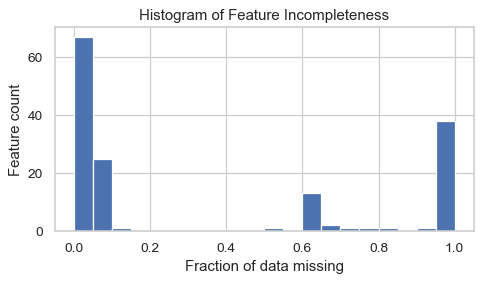

In [10]:
missing_fractions = loans.isnull().mean().sort_values(ascending=False)
plt.figure(figsize=(6,3), dpi=90)
missing_fractions.plot.hist(bins=20)
plt.title('Histogram of Feature Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Feature count')
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))


In [11]:
loans.drop(labels=drop_list, axis=1, inplace=True)

In [12]:
keep_list = ['addr_state', 'annual_inc', 'application_type', 'dti'
             , 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low'
             , 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'issue_d'
             , 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose'
             , 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code']


In [13]:
drop_list = [col for col in loans.columns if col not in keep_list]
loans.drop(labels=drop_list, axis=1, inplace=True)

In [14]:
loans.shape

(1345310, 31)

In [15]:
loans['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid     0.800374
Charged Off    0.199626
Name: loan_status, dtype: float64

In [16]:
# do only once
loans.drop('id', axis=1, inplace=True)
loans.drop('grade', axis=1, inplace=True)
loans.drop(labels='title', axis=1, inplace=True)
loans.drop(labels='emp_title', axis=1, inplace=True)
loans['log_annual_inc'] = loans['annual_inc'].apply(lambda x: np.log10(x+1))
loans.drop('annual_inc', axis=1, inplace=True)
loans.drop(labels='zip_code', axis=1, inplace=True)
loans['fico_score'] = 0.5*loans['fico_range_low'] + 0.5*loans['fico_range_high']
loans.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)
loans.drop('revol_bal', axis=1, inplace=True)

In [17]:
#do only once
loans['issue_d'] = pd.to_datetime(loans['issue_d'])
loans["issue_d"]=loans['issue_d'].dt.year
loans['earliest_cr_line'] = loans['earliest_cr_line'].apply(lambda s: int(s[-4:]))

In [18]:
# do only once
loans['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)
loans['emp_length'].replace('< 1 year', '0 years', inplace=True)
def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
loans['emp_length'] = loans['emp_length'].apply(emp_length_to_int)

In [19]:
loans.shape

(1345310, 24)

In [20]:
def convert_class(dataset,outcome): # 给numbers分组
    y = dataset[outcome].values.tolist()
    for (i, item) in enumerate(y):
        if item in ("Fully Paid"):
            y[i] = 0
        if item in ("Charged Off"):
            y[i] = 1
    return y

def convert_column(dataset, num_column, cat_column):
    df_num = dataset[num_column]
 
    df_cat = dataset[cat_column].astype(str) #把category 换成数字
    encoder = LabelEncoder()
    df_cat = df_cat.apply(encoder.fit_transform)
    
    return pd.concat([df_cat,df_num],axis=1)

In [21]:
loans.head()

loan_amnt        term  int_rate  installment sub_grade  emp_length  \
0     3600.0   36 months     13.99       123.03        C4        10.0   
1    24700.0   36 months     11.99       820.28        C1        10.0   
2    20000.0   60 months     10.78       432.66        B4        10.0   
4    10400.0   60 months     22.45       289.91        F1         3.0   
5    11950.0   36 months     13.44       405.18        C3         4.0   

  home_ownership verification_status  issue_d loan_status             purpose  \
0       MORTGAGE        Not Verified     2015  Fully Paid  debt_consolidation   
1       MORTGAGE        Not Verified     2015  Fully Paid      small_business   
2       MORTGAGE        Not Verified     2015  Fully Paid    home_improvement   
4       MORTGAGE     Source Verified     2015  Fully Paid      major_purchase   
5           RENT     Source Verified     2015  Fully Paid  debt_consolidation   

  addr_state    dti  earliest_cr_line  open_acc  pub_rec  revol_util  \
0         PA   5.91              2003       7.0      0.0        29.7   
1         SD  16.06              1999      22.0      0.0        19.2   
2         IL  10.78              2000       6.0      0.0        56.2   
4         PA  25.37              1998      12.0      0.0        64.5   
5         GA  10.20              1987       5.0      0.0        68.4   

   total_acc initial_list_status application_type  mort_acc  \
0       13.0                   w       Individual       1.0   
1       38.0                   w       Individual       4.0   
2       18.0                   w        Joint App       5.0   
4       35.0                   w       Individual       6.0   
5        6.0                   w       Individual       0.0   

   pub_rec_bankruptcies  log_annual_inc  fico_score  
0                   0.0        4.740371       677.0  
1                   0.0        4.812920       717.0  
2                   0.0        4.799347       697.0  
4                   0.0        5.018842       697.0  
5                   0.0        4.531492       692.0

In [22]:
cat_col= ["term","sub_grade","home_ownership","verification_status",
          "purpose","addr_state","initial_list_status","application_type"]

num_col = ["loan_amnt","int_rate","installment","issue_d","dti","earliest_cr_line","emp_length",
           "open_acc","pub_rec","revol_util","total_acc","mort_acc","pub_rec_bankruptcies","fico_score","loan_status"]
loans = convert_column(loans,num_col,cat_col)

In [23]:
loans["y"] = pd.factorize(loans["loan_status"])[0]
loans.drop('loan_status', axis=1, inplace=True)

In [24]:
loans["y"].value_counts()

0    1076751
1     268559
Name: y, dtype: int64

In [25]:
loans["emp_length"].fillna(0,inplace = True)
loans["dti"].fillna(loans["dti"].mean(),inplace = True)
loans["mort_acc"].fillna(loans["mort_acc"].mean(),inplace = True)
loans["pub_rec_bankruptcies"].fillna(loans["pub_rec_bankruptcies"].mean(),inplace = True)
loans["revol_util"].fillna(loans["revol_util"].mean(),inplace = True)

In [26]:
loans.shape

(1345310, 23)

In [27]:
loans.sample(3)

term  sub_grade  home_ownership  verification_status  purpose  \
1277358     0          2               5                    0        1   
416353      0          3               5                    0        1   
148560      0          5               5                    1        2   

         addr_state  initial_list_status  application_type  loan_amnt  \
1277358          43                    1                 0    10800.0   
416353            4                    0                 0    11000.0   
148560           43                    0                 0    12000.0   

         int_rate  installment  issue_d    dti  earliest_cr_line  emp_length  \
1277358      7.12       334.07     2014   6.10              1997        10.0   
416353       7.49       342.12     2015   8.60              2007         9.0   
148560       8.18       377.04     2015  20.11              1997        10.0   

         open_acc  pub_rec  revol_util  total_acc  mort_acc  \
1277358      10.0      0.0        34.3       23.0       0.0   
416353        5.0      0.0        46.1       11.0       0.0   
148560       17.0      1.0        63.7       28.0       1.0   

         pub_rec_bankruptcies  fico_score  y  
1277358                   0.0       722.0  0  
416353                    0.0       742.0  0  
148560                    0.0       667.0  0

In [28]:
#loans_train = df.loc[df['issue_d'] <  df['issue_d'].quantile(0.9)]
#loans_test =  df.loc[df['issue_d'] >= df['issue_d'].quantile(0.9)]

In [29]:
#X_train = loans_train.drop("y",axis =1)
#y_train = loans_train["y"]
#X_test = loans_test.drop('y', axis=1)
#y_test = loans_test["y"]

In [30]:
#X_train.shape

In [31]:
def split_(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    return X_train, X_test, y_train, y_test

def cv(data,k):
    fold = KFold(k)
    aucs = []
    #mses = []
    accuracys =[]
    
    #F1s =[]
    #precisions=[]
    #recalls=[]
    mccs=[]
    for train_idx, vali_idx in fold.split(data): 
        cv_train,cv_validate=data.iloc[train_idx,:], data.iloc[vali_idx,:]
        X_train = cv_train[cv_train.columns[:-1]]
        y_train = cv_train[cv_train.columns[-1]]
        X_test = cv_validate[cv_validate.columns[:-1]]
        y_test = cv_validate[cv_validate.columns[-1]]
        criterion = "gini"
        auc,accuracy,mcc = rf(X_train, X_test, y_train, y_test,criterion)
        aucs.append(auc)
        
        accuracys.append(accuracy)
        F1s.append(F1)
        precisions.append(precision)
        recalls.append(recall)
        mccs.append(mcc)
        
    #mean_auc = round(np.mean(aucs),3)    
    return aucs,accuracys,mccs#,F1s

def rf(X_train, X_test, y_train, y_test,criterion):
    forest = RandomForestClassifier(n_estimators=200, min_samples_split = 60, max_features = 6,n_jobs =-1, criterion=criterion)
    forest.fit(X_train, y_train)
    
    y_predicted = forest.predict_proba(X_test)[:, 1]
    y_predict_test  = forest.predict(X_test)
    #print(y_predict_test[20:40])
    #y_score = forest.decision_function(X_test)
    #unique, counts = np.unique(y_predict_test, return_counts=True)
    #print(dict(zip(unique, counts)))
    ap = metrics.average_precision_score(y_test, y_predicted) 
    
    auc = metrics.roc_auc_score(y_test, y_predicted) 
    #accuracy  = metrics.accuracy_score(y_test, y_predict_test)
    
    #F1         = metrics.f1_score(y_test, y_predict_test,labels=np.unique(y_predict_test))
    #precision  = metrics.precision_score(y_test, y_predict_test)
    ma = metrics.confusion_matrix(y_test, y_predict_test, labels=None, sample_weight=None)
    #recall     = metrics.recall_score(y_test, y_predict_test)
    cost = 2318*ma[0][0]-7274*ma[1][0]
    #mcc = metrics.matthews_corrcoef(y_test, y_predict_test)
    #ROC_Curve(forest, auc, X_test,y_test)
    #tn, fp, fn, tp = ma([0, 1, 0, 1], [1, 1, 1, 0]).ravel()
    #PR_curve(y_test, y_predicted)
    #mcc = metrics.average_precision_score(y_test, y_predicted)
    #print('AUC: {:0.3f}'.format(maxx))
    #print(ma)
    return auc,ap,cost


In [32]:
data = loans[loans["dti"] < 100]
data.shape

(1344775, 23)

In [33]:
olddata = data[data["issue_d"] <= 2013]
testset = data[data["issue_d"] == 2017].sample(10000)
data.shape

(1344775, 23)

In [34]:
from sklearn.metrics import precision_recall_curve,average_precision_score
def PR_curve(y_test, y_score_rf):
    average_precision = average_precision_score(y_test, y_score_rf)
    precision, recall, _ = precision_recall_curve(y_test, y_score_rf)

    plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [35]:
def ROC_Curve(rf, auc, X_test,y_test):
    one_hot_encoder = OneHotEncoder()
    #rf_fit = rf.fit(X_train, y_train)
    #fit = one_hot_encoder.fit(rf.apply(X_train))
    y_predicted = rf.predict_proba(X_test)[:, 1]
    false_positive, true_positive, _ = metrics.roc_curve(y_test, y_predicted)
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(false_positive, true_positive, color='darkorange', label='Random Forest')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve (area = %0.2f)' % auc)
    plt.legend(loc='best')
    plt.show()

In [36]:
tt = olddata.sample(100000)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tt[tt.columns[:-1]], tt[tt.columns[-1]], test_size=0.2)
auc, ap,ma = rf(X_train, X_test, y_train, y_test,"gini")
print(auc, ap, ma)

In [56]:
8478*2318-7274*1517

8617346

In [65]:
ma[0][0],ma[1][0]

(8502, 1496)

In [ ]:
def rf_observation(old,testset,row_num):
    aucs_all = []
    aps_all =[]
    costs_all = []
   
    for i in np.arange(25):
        df = old.sample(row_num)
        X_train = df[df.columns[:-1]]
        y_train = df[df.columns[-1]]
        X_test = testset[testset.columns[:-1]]
        y_test = testset[testset.columns[-1]]
        criterion = "gini"
        auc, ap, cost = rf(X_train, X_test, y_train, y_test, criterion)
        aucs_all.append(auc)
        #accuracys_all.append(accuracy)
        costs_all.append(cost)
        aps_all.append(ap)
       
        #precisions.append(precision)
        #recalls.append(recall)
        
    return aucs_all,aps_all,  costs_all


In [ ]:
obse = [5000,10000,30000,50000,100000,150000,200000]
#rows = [6250,12500,25000,37500,62500,100000,125000,187500]

aucs = []
aps =[]
costs =[]

#ave_times = []
for row_num in obse:
    print(row_num)
 #   start_time = time.time()
    aucs_all, aps_all,costs_all = rf_observation(olddata,testset,row_num)
  #  ave_time = (time.time() - start_time)/25
    #print("--- %s seconds ---" %ave_time)
    aucs.append(aucs_all)
    #mse.append(mses_all)
    #accuracys.append(accuracys_all)
    aps.append(aps_all)
    #precision.append(precisions_all)
    #recall.append(recalls_all)
    costs.append(costs_all)
    #ave_times.append(ave_time)

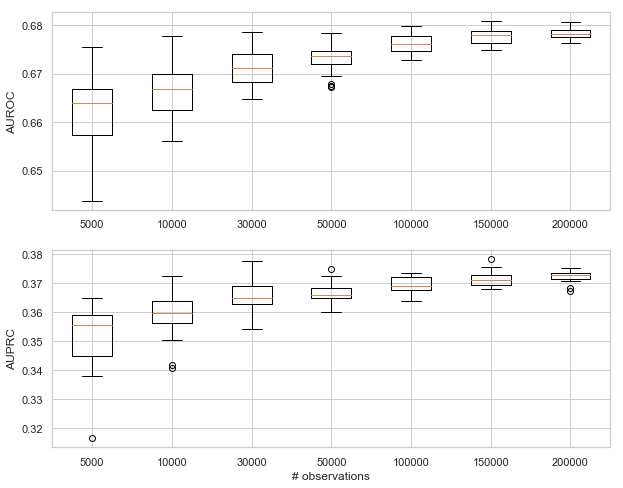

In [128]:
# Create a figure instance
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Create the boxplot
ax1.boxplot(aucs)
#ax2.boxplot(mccs)
#ax3.boxplot(costs) 
ax2.boxplot(aps) 
#ax5.boxplot(f1s) 
#ax6.boxplot(precisions) 
#ax7.boxplot(recalls) 


#ax3.plot(rows,ave_times,"-o")
## Custom x-axis labels
ax2.set_xticklabels(obse)
ax1.set_xticklabels(obse)
#ax3.set_xticklabels(obse)
# Save the figure

#f, ax = plt.subplots(figsize=(5,4), dpi=125)
#ax.plot(rows, aucs, label='Random Forest (sklearn)')
ax2.set_xlabel('# observations'); ax1.set_ylabel('AUROC');ax2.set_ylabel('AUPRC');#ax3.set_ylabel('Profit');
ax1.set_xlabel('');
#ax3.set_ylabel("RF average run time");
fig.savefig('fig sizes.pdf', bbox_inches='tight')


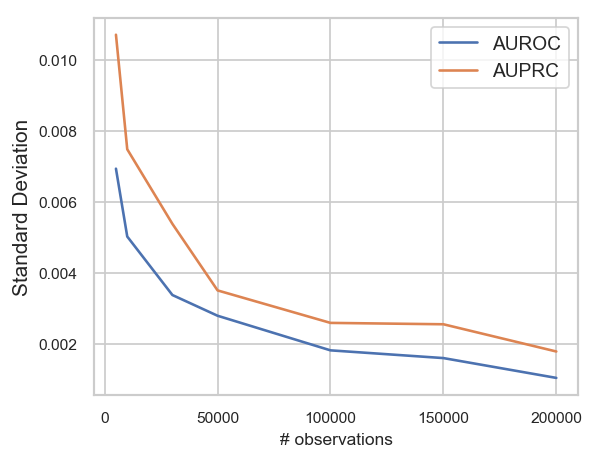

In [127]:
stds1 =[]
stds2 =[]
stds3 =[]

for i in np.arange(len(aucs)):
    std1 = np.std(aucs[i])
    stds1.append(std1)
    
    std2 = np.std(aps[i])
    stds2.append(std2)
    std3 = np.std(costs[i])
    stds3.append(std3)

fig, ax =plt.subplots(figsize=(5,4), dpi=125)
ax.plot(obse,stds1,"-",label = "AUROC")
ax.plot(obse,stds2,"-",label = "AUPRC")
#ax.plot(obse,stds3,"-",label = "Cost")
#ax.plot(obse,stds4,"-",label = "aps")
#ax.plot(obse,stds5,"-",label = "f1")
#ax.plot(obse,stds6,"-",label = "precision")
#ax.plot(obse,stds7,"-",label = "recall")

ax.xaxis.label.set_fontsize(10)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(9)
ax.set_xlabel("# observations");ax.set_ylabel('Standard Deviation');ax.legend();
fig.savefig('pr auc std.pdf', bbox_inches='tight')

In [112]:
data[data["issue_d"]==2013]["y"].value_counts()
21024/113780

0.184777641061698

In [110]:
for i in [0,1,2,3,4]:
    allv = data[data["issue_d"]==i+2014]["y"].value_counts()   
    pro = allv[1]/(allv[1]+allv[0])
    print(pro)


0.18449408790598024
0.2018522808671316
0.23281584344935619
0.23112423304716206
0.15729576662095496


In [119]:
aucs_b = []  # 5 folds  *5 test on 50000 ###  original model
ap_b =[]
cost_b = []
#mcc_b=[]
#f1_b=[]
aucs_new_b = [[],[],[],[],[]]    
ap_new_b = [[],[],[],[],[]]
#mcc_new_b=[[],[],[],[],[]]
#f1_new_b= [[],[],[],[],[]]
cost_new_b =[[],[],[],[],[]]  
for i in np.arange(5):
    traindata = olddata.sample(50000)
    fold = KFold(5,shuffle = True)  
    print(i)
    for train_idx, vali_idx in fold.split(traindata): 
        cv_train,cv_validate=traindata.iloc[train_idx,:], traindata.iloc[vali_idx,:]
        X_train = cv_train[cv_train.columns[:-1]]
        y_train = cv_train[cv_train.columns[-1]]
        X_test = cv_validate[cv_validate.columns[:-1]]
        y_test = cv_validate[cv_validate.columns[-1]]
        criterion = "gini"
        
        forest = RandomForestClassifier(n_estimators=70, max_features =6,min_samples_leaf =60, n_jobs = -1,criterion=criterion)
        forest.fit(X_train, y_train)
        auc = metrics.roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1]) 
        ap = metrics.average_precision_score(y_test, forest.predict_proba(X_test)[:, 1]) 
        #mcc = metrics.matthews_corrcoef(y_test, forest.predict(X_test))
        #F1  = metrics.f1_score(y_test, forest.predict(X_test),labels=np.unique(forest.predict(X_test)))
        aucs_b.append(auc)
        ap_b.append(ap)
        ma = metrics.confusion_matrix(y_test, forest.predict(X_test), labels=None, sample_weight=None)
        cost = 2318*ma[0][0]-7274*ma[1][0]
        cost_b.append(cost)
        
        for year in [0,1,2,3,4]:
            testdata = data[data["issue_d"] == (year+2014)].sample(10000)
            X_test = testdata[testdata.columns[:-1]]
            y_test = testdata[testdata.columns[-1]]
            auc_ = metrics.roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1]) 
            ap_ = metrics.average_precision_score(y_test, forest.predict_proba(X_test)[:, 1]) 
            #mcc_ = metrics.matthews_corrcoef(y_test, forest.predict(X_test))
            #F1_  = metrics.f1_score(y_test, forest.predict(X_test),labels=np.unique(forest.predict(X_test)))
            ma_ = metrics.confusion_matrix(y_test, forest.predict(X_test), labels=None, sample_weight=None)
            cost_ = 2318*ma_[0][0]-7274*ma_[1][0]
            aucs_new_b[year].append(auc_)
            ap_new_b[year].append(ap_)
            cost_new_b[year].append(cost_)

0
1
2
3
4


In [121]:
#mccs=[]   ### baseline model
aucs_onnew = [[],[],[],[],[]]
ap_onnew = [[],[],[],[],[]]
cost_onnew = [[],[],[],[],[]]
#f1_onnew = [[],[],[],[],[]]

for year in [0,1,2,3,4]: 
    print(year)
    for i in np.arange(5):
        traindata = data[data["issue_d"] == (year + 2014)].sample(50000)
        fold = KFold(5,shuffle = True)  
        for train_idx, vali_idx in fold.split(traindata): 
            cv_train,cv_validate=traindata.iloc[train_idx,:], traindata.iloc[vali_idx,:]
            X_train = cv_train[cv_train.columns[:-1]]
            y_train = cv_train[cv_train.columns[-1]]
            X_test = cv_validate[cv_validate.columns[:-1]]
            y_test = cv_validate[cv_validate.columns[-1]]
            criterion = "gini"
            forest = RandomForestClassifier(n_estimators=70, max_features =6,min_samples_leaf =60,n_jobs = -1,criterion=criterion)
            forest.fit(X_train, y_train)
            auc = metrics.roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1]) 
            aucs_onnew[year].append(auc)
            
            ap_ = metrics.average_precision_score(y_test, forest.predict_proba(X_test)[:, 1]) 
            ap_onnew[year].append(ap_)
            ma = metrics.confusion_matrix(y_test, forest.predict(X_test), labels=None, sample_weight=None)
            cost = 2318*ma[0][0]-7274*ma[1][0]
            cost_onnew[year].append(cost)
        

0
1
2
3
4


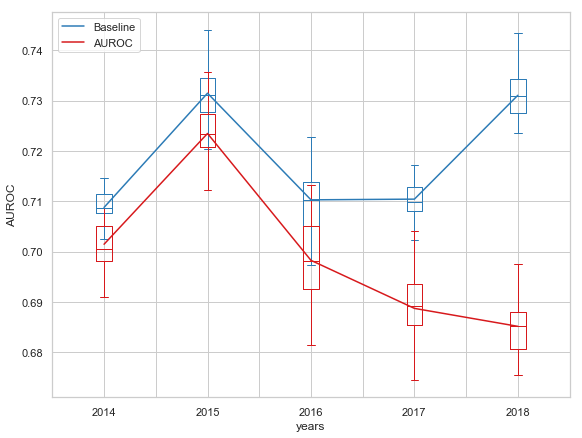

In [123]:
ee=[]
for i in aucs_onnew:
    e = sum(i)/25
    ee.append(e)
eee=[]
for i in aucs_new_b:
    e = sum(i)/25
    eee.append(e)

ticks = ["",2014,"",2015,"",2016,"",2017,"",2018]

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure(figsize=(8,6))

bpl = plt.boxplot(aucs_onnew, positions=[2,6,10,14,18], sym='', widths=0.6)
bpr = plt.boxplot(aucs_new_b, positions=[2,6,10,14,18], sym='', widths=0.6)
#bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#2C7BB6') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#D7191C')

#bp3 = plt.boxplot(aucs_new_g, positions=[6,10,14,18], sym='', widths=0.6)
#set_box_color(bp3,'#31a354')

#bp4 = plt.boxplot(aucs_new_p, positions=[10,14,18], sym='', widths=0.6)
#set_box_color(bp3,'#756bb1')


# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#2C7BB6', label='Baseline')
plt.plot([], c='#D7191C', label='AUROC')

#plt.plot([], c='#31a354', label='Updated Models')

#plt.plot([6,10,14,18],ee,"-",color = '#31a354')
#plt.plot([10,14,18],eee,"-",color = '#756bb1')
plt.plot([2,6,10,14,18],eee,"-",color = '#D7191C')
plt.plot([2,6,10,14,18],ee,"-",color = "#2C7BB6")
plt.legend()
plt.xticks(range(0, len(ticks) *2+1, 2), ticks)
#plt.xlim(-2, len(ticks)*2)
#plt.ylim(0, 8)
plt.tight_layout()
plt.xlabel('years'); plt.ylabel('AUROC');
plt.savefig('aucbaseline.png',bbox_inches='tight')

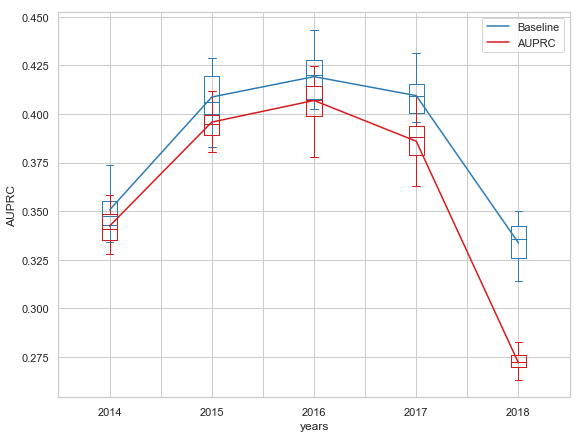

In [70]:
ee=[]
for i in ap_onnew:
    e = sum(i)/25
    ee.append(e)
eee=[]
for i in ap_new_b:
    e = sum(i)/25
    eee.append(e)

ticks = ["",2014,"",2015,"",2016,"",2017,"",2018]

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure(figsize=(8,6))

bpl = plt.boxplot(ap_onnew, positions=[2,6,10,14,18], sym='', widths=0.6)
bpr = plt.boxplot(ap_new_b, positions=[2,6,10,14,18], sym='', widths=0.6)
#bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#2C7BB6') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#D7191C')

#bp3 = plt.boxplot(aucs_new_g, positions=[6,10,14,18], sym='', widths=0.6)
#set_box_color(bp3,'#31a354')

#bp4 = plt.boxplot(aucs_new_p, positions=[10,14,18], sym='', widths=0.6)
#set_box_color(bp3,'#756bb1')


# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#2C7BB6', label='Baseline')
plt.plot([], c='#D7191C', label='AUPRC')

#plt.plot([], c='#31a354', label='Updated Models')

#plt.plot([6,10,14,18],ee,"-",color = '#31a354')
#plt.plot([10,14,18],eee,"-",color = '#756bb1')
plt.plot([2,6,10,14,18],eee,"-",color = '#D7191C')
plt.plot([2,6,10,14,18],ee,"-",color = "#2C7BB6")
plt.legend()
plt.xticks(range(0, len(ticks) *2+1, 2), ticks)
#plt.xlim(-2, len(ticks)*2)
#plt.ylim(0, 8)
plt.tight_layout()
plt.xlabel('years'); plt.ylabel('AUPRC');
plt.savefig('aucbaseline22.png',bbox_inches='tight')

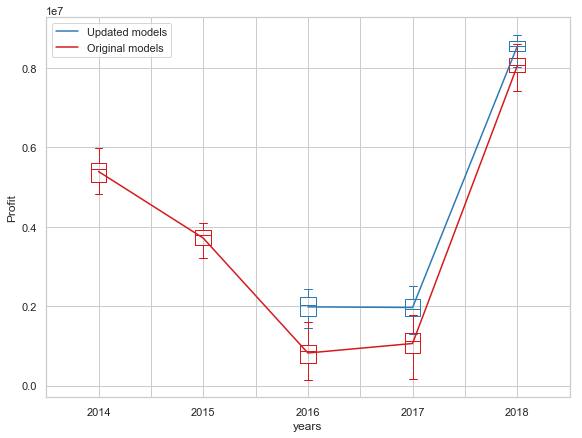

In [126]:
ee=[]
for i in cost_new_g:
    e = sum(i)/25
    ee.append(e)
eee=[]
for i in cost_new_b:
    e = sum(i)/25
    eee.append(e)

ticks = ["",2014,"",2015,"",2016,"",2017,"",2018]

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure(figsize=(8,6))

bpl = plt.boxplot(cost_new_g, positions=[10,14,18], sym='', widths=0.6)
bpr = plt.boxplot(cost_new_b, positions=[2,6,10,14,18], sym='', widths=0.6)
#bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#2C7BB6') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#D7191C')

#bp3 = plt.boxplot(aucs_new_g, positions=[6,10,14,18], sym='', widths=0.6)
#set_box_color(bp3,'#31a354')

#bp4 = plt.boxplot(aucs_new_p, positions=[10,14,18], sym='', widths=0.6)
#set_box_color(bp3,'#756bb1')


# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#2C7BB6', label='Updated models')
plt.plot([], c='#D7191C', label='Original models')

#plt.plot([], c='#31a354', label='Updated Models')

#plt.plot([6,10,14,18],ee,"-",color = '#31a354')
#plt.plot([10,14,18],eee,"-",color = '#756bb1')
plt.plot([10,14,18],ee,"-",color = "#2C7BB6")
plt.plot([2,6,10,14,18],eee,"-",color = '#D7191C')
plt.legend()
plt.xticks(range(0, len(ticks) *2+1, 2), ticks)
#plt.xlim(-2, len(ticks)*2)
#plt.ylim(0, 8)
plt.tight_layout()
plt.xlabel('years'); plt.ylabel('Profit');
#plt.savefig('profit.png',bbox_inches='tight')

In [130]:
ee

[1982209.76, 1966686.16, 8543623.12]

In [133]:
8543623-8050068

493555

In [128]:
eee

[5391178.8, 3715357.28, 820597.2, 1060688.16, 8050068.4]

In [147]:
ee=[]
for i in ap_onnew:
    e = sum(i)/25
    ee.append(e)
eee=[]
for i in ap_new_b:
    e = sum(i)/25
    eee.append(e)


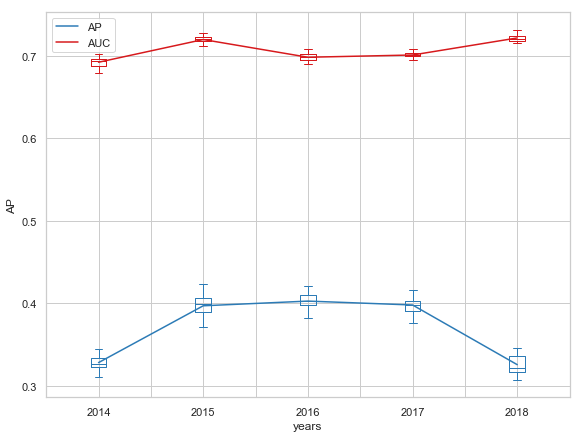

In [120]:
ee=[]
for i in ap_onnew:
    e = sum(i)/25
    ee.append(e)
eee=[]
for i in aucs_onnew:
    e = sum(i)/25
    eee.append(e)

ticks = ["",2014,"",2015,"",2016,"",2017,"",2018]

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure(figsize=(8,6))

bpl = plt.boxplot(ap_onnew, positions=[2,6,10,14,18], sym='', widths=0.6)
bpr = plt.boxplot(aucs_onnew, positions=[2,6,10,14,18], sym='', widths=0.6)
#bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#2C7BB6') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#D7191C')

#bp3 = plt.boxplot(aucs_new_g, positions=[6,10,14,18], sym='', widths=0.6)
#set_box_color(bp3,'#31a354')

#bp4 = plt.boxplot(aucs_new_p, positions=[10,14,18], sym='', widths=0.6)
#set_box_color(bp3,'#756bb1')


# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#2C7BB6', label='AP')
plt.plot([], c='#D7191C', label='AUC')

#plt.plot([], c='#31a354', label='Updated Models')

#plt.plot([6,10,14,18],ee,"-",color = '#31a354')
#plt.plot([10,14,18],eee,"-",color = '#756bb1')
plt.plot([2,6,10,14,18],eee,"-",color = '#D7191C')
plt.plot([2,6,10,14,18],ee,"-",color = "#2C7BB6")
plt.legend()
plt.xticks(range(0, len(ticks) *2+1, 2), ticks)
#plt.xlim(-2, len(ticks)*2)
#plt.ylim(0, 8)
plt.tight_layout()
plt.xlabel('years'); plt.ylabel('AP');
#plt.savefig('ap baseline.png',bbox_inches='tight')

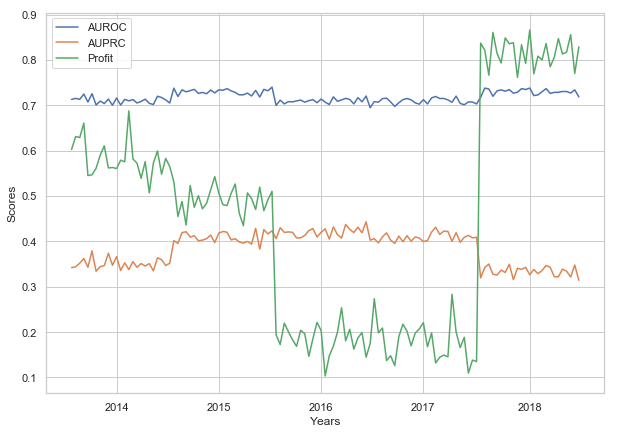

In [111]:
fig,ax = plt.subplots(figsize=(10, 7))
ax.plot(aucs_onnew[0]+aucs_onnew[1]+aucs_onnew[2]+aucs_onnew[3]+aucs_onnew[4],label = "AUROC");
ax.plot(ap_onnew[0]+ap_onnew[1]+ap_onnew[2]+ap_onnew[3]+ap_onnew[4],label = "AUPRC");
list = [i/10000000 for i in cost_onnew[0]+cost_onnew[1]+cost_onnew[2]+cost_onnew[3]+cost_onnew[4]]
ax.plot(list,label = "Profit");
years =[2014,2015,2016,2017,2018]
#ax.plot([11,36,61,86,112],[0.18449408790598024,0.2018522808671316,0.23281584344935619,0.23112423304716206,0.15729576662095496],"o")
ax.set_xticklabels(years);
ax.set_xticks([11,36,61,86,112])
ax.set_xlabel("Years");ax.set_ylabel('Scores');ax.legend();
plt.savefig('lines.png',bbox_inches='tight')

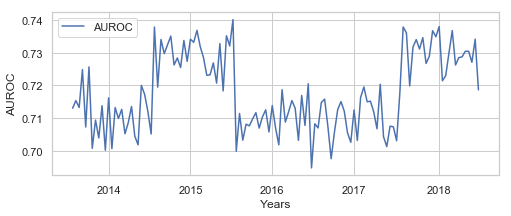

In [118]:
fig,ax = plt.subplots(figsize=(8, 3))
ax.plot(aucs_onnew[0]+aucs_onnew[1]+aucs_onnew[2]+aucs_onnew[3]+aucs_onnew[4],label = "AUROC");
years =[2014,2015,2016,2017,2018]
#ax.plot([11,36,61,86,112],[0.18449408790598024,0.2018522808671316,0.23281584344935619,0.23112423304716206,0.15729576662095496],"o")
ax.set_xticklabels(years);
ax.set_xticks([11,36,61,86,112])
ax.set_xlabel("Years");ax.set_ylabel('AUROC');ax.legend();
plt.savefig('auclines.png',bbox_inches='tight')

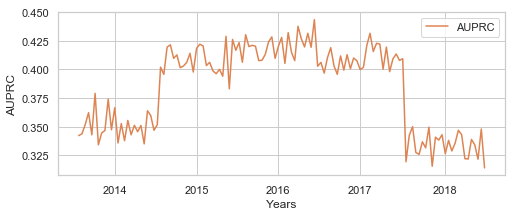

In [117]:
fig,ax = plt.subplots(figsize=(8, 3))
ax.plot(11,0.38)
ax.plot(ap_onnew[0]+ap_onnew[1]+ap_onnew[2]+ap_onnew[3]+ap_onnew[4],label = "AUPRC");

years =[2014,2015,2016,2017,2018]
#ax.plot([11,36,61,86,112],[0.18449408790598024,0.2018522808671316,0.23281584344935619,0.23112423304716206,0.15729576662095496],"o")
ax.set_xticklabels(years);
ax.set_xticks([11,36,61,86,112])
ax.set_xlabel("Years");ax.set_ylabel('AUPRC');ax.legend();
plt.savefig('aplines.png',bbox_inches='tight')

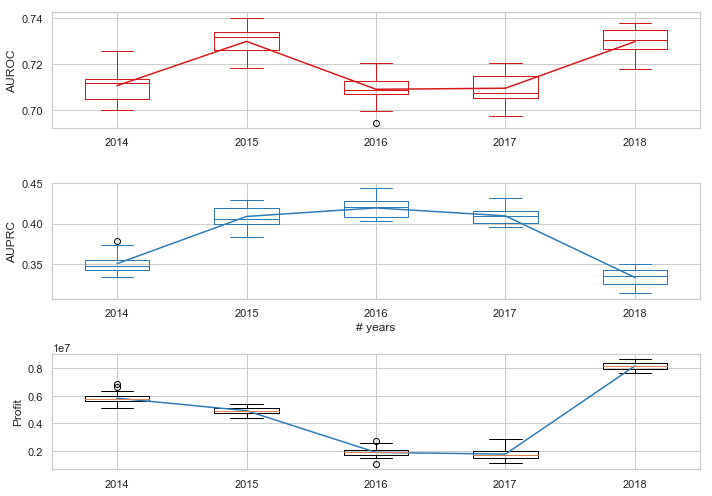

In [98]:
ee=[]
for i in ap_onnew:
    e = sum(i)/25
    ee.append(e)
eee=[]
for i in aucs_onnew:
    e = sum(i)/25
    eee.append(e)
eg=[]
for i in cost_onnew:
    e = sum(i)/25
    eg.append(e)

# Create a figure instance
fig2, (ax1, ax2,ax3) = plt.subplots(nrows = 3, ncols=1, figsize=(10, 7))

# Create the boxplot
au = ax1.boxplot(aucs_onnew)
ap = ax2.boxplot(ap_onnew)
ac = ax3.boxplot(cost_onnew)
years = [2014,2015,2016,2017,2018]
set_box_color(ap, '#2C7BB6') # colors are from http://colorbrewer2.org/
set_box_color(au, '#D7191C')

ax1.set_xticklabels(years)
ax2.set_xticklabels(years)
ax3.set_xticklabels(years)
ax1.plot([1,2,3,4,5],eee,"-",color = '#D7191C')
ax2.plot([1,2,3,4,5],ee,"-",color = "#2C7BB6")
ax3.plot([1,2,3,4,5],eg,"-",color = "#2C7BB6")
#ax.plot(rows, aucs, label='Random Forest (sklearn)')
ax2.set_xlabel('# years'); ax1.set_ylabel('AUROC');ax2.set_ylabel('AUPRC');ax3.set_ylabel('Profit');
ax1.set_xlabel('');
#ax3.set_ylabel("RF average run time");
plt.tight_layout()

#fig2.savefig('apauc.png', bbox_inches='tight')

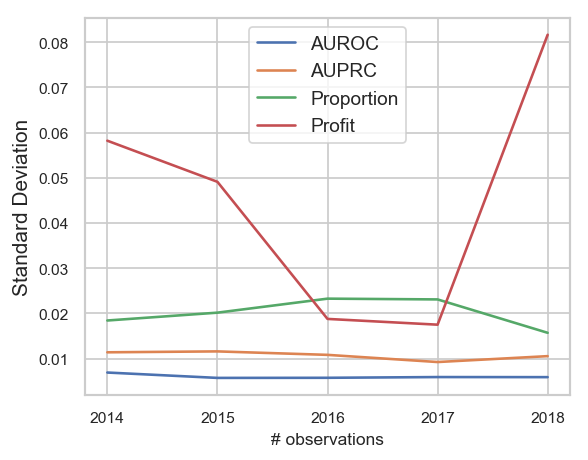

In [79]:
pro = [0.18449408790598024/10,
0.2018522808671316/10,
0.23281584344935619/10,
0.23112423304716206/10,
0.15729576662095496/10]
c = [np.mean(i)/100000000 for i in cost_onnew]
stds_auc =[]
stds_ap =[]
years =[2014,2015,2016,2017,2018]

for i in np.arange(len(aucs_onnew)):
    std1 = np.std(aucs_onnew[i])
    stds_auc.append(std1)
    
    std2 = np.std(ap_onnew[i])
    stds_ap.append(std2)
  
fig, ax =plt.subplots(figsize=(5,4), dpi=125)
ax.plot(years,stds_auc,"-",label = "AUROC")
ax.plot(years,stds_ap,"-",label = "AUPRC")
ax.plot(years,pro,"-",label = "Proportion")
ax.plot(years,c,"-",label = "Profit")
#ax.plot(obse,stds5,"-",label = "f1")
#ax.plot(obse,stds6,"-",label = "precision")
#ax.plot(obse,stds7,"-",label = "recall")

ax.xaxis.label.set_fontsize(10)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(9)
ax.set_xlabel("# observations");ax.set_ylabel('Standard Deviation');ax.legend();
fig.savefig('praucpro.png', bbox_inches='tight')

In [73]:
 # train on new data green line model # 5 folds  *5 test on 10000
aucs_g = [] 
ap_g =[]
cost_g =[]

#accuracys =[]
#mccs=[]
aucs_new_g = [[],[],[]]  # contains the 6*5 data points from the first model    
cost_new_g = [[],[],[]]
ap_new_g = [[],[],[]]
for i in np.arange(5):
    traindata = data[data["issue_d"] == 2015].sample(50000)
    fold = KFold(5,shuffle = True)  
    print(i)
    for train_idx, vali_idx in fold.split(traindata): 
        cv_train,cv_validate=traindata.iloc[train_idx,:], traindata.iloc[vali_idx,:]
        X_train = cv_train[cv_train.columns[:-1]]
        y_train = cv_train[cv_train.columns[-1]]
        X_test = cv_validate[cv_validate.columns[:-1]]
        y_test = cv_validate[cv_validate.columns[-1]]
        criterion = "gini"
        forest = RandomForestClassifier(n_estimators=70, max_features =6,min_samples_leaf =60, n_jobs = -1,criterion=criterion)
        forest.fit(X_train, y_train)
        auc = metrics.roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1]) 
        aucs_g.append(auc)
        
        ap = metrics.average_precision_score(y_test, forest.predict_proba(X_test)[:, 1]) 
        ap_g.append(ap)
        ma = metrics.confusion_matrix(y_test, forest.predict(X_test), labels=None, sample_weight=None)
        cost = 2318*ma[0][0]-7274*ma[1][0]
        cost_g.append(cost)
        
        for year in [0,1,2]:
            testdata = data[data["issue_d"] == (year+2016)].sample(10000)
            X_test = testdata[testdata.columns[:-1]]
            y_test = testdata[testdata.columns[-1]]
            auc_ = metrics.roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1]) 
            aucs_new_g[year].append(auc_)
            #accuracy_ = metrics.accuracy_score(y_test, forest.predict(X_test))
            #mcc_ = metrics.matthews_corrcoef(y_test, forest.predict(X_test))
            ap_ = metrics.average_precision_score(y_test, forest.predict_proba(X_test)[:, 1]) 
            ap_new_g[year].append(ap_)
            ma = metrics.confusion_matrix(y_test, forest.predict(X_test), labels=None, sample_weight=None)
            cost_ = 2318*ma[0][0]-7274*ma[1][0]
            cost_new_g[year].append(cost_)
          

0
1
2
3
4


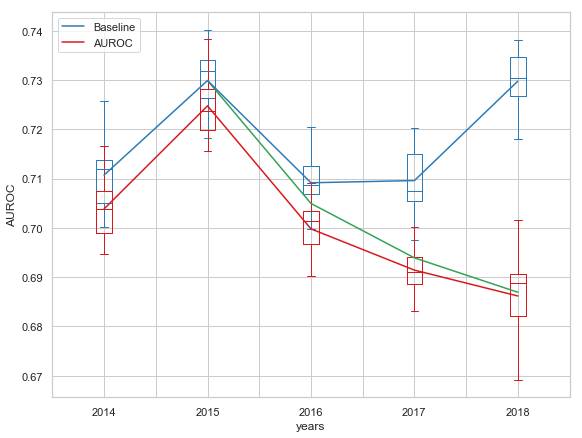

In [78]:
ee=[]
for i in aucs_onnew:
    e = sum(i)/25
    ee.append(e)
eee=[]
for i in aucs_new_b:
    e = sum(i)/25
    eee.append(e)
    
eg=[]
for i in aucs_new_g:
    e = sum(i)/25
    eg.append(e)
eg.insert(0,ee[1])

ticks = ["",2014,"",2015,"",2016,"",2017,"",2018]
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
plt.figure(figsize=(8,6))
bpl = plt.boxplot(aucs_onnew, positions=[2,6,10,14,18], sym='', widths=0.6)
bpr = plt.boxplot(aucs_new_b, positions=[2,6,10,14,18], sym='', widths=0.6)
#bpg = plt.boxplot(aucs_new_g, positions=[10,14,18])
set_box_color(bpl, '#2C7BB6') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#D7191C')

#bp3 = plt.boxplot(aucs_new_g, positions=[10,14,18], sym='', widths=0.6)
#set_box_color(bp3,'#31a354')

#bp4 = plt.boxplot(aucs_new_p, positions=[10,14,18], sym='', widths=0.6)
#set_box_color(bp3,'#756bb1')


# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#2C7BB6', label='Baseline')
plt.plot([], c='#D7191C', label='AUROC')

#plt.plot([], c='#31a354', label='Updated Models')

#plt.plot([6,10,14,18],ee,"-",color = '#31a354')
plt.plot([6,10,14,18],eg,"-",color = '#31a354')
plt.plot([2,6,10,14,18],eee,"-",color = '#D7191C')
plt.plot([2,6,10,14,18],ee,"-",color = "#2C7BB6")
plt.legend()
plt.xticks(range(0, len(ticks) *2+1, 2), ticks)
#plt.xlim(-2, len(ticks)*2)
#plt.ylim(0, 8)
plt.tight_layout()
plt.xlabel('years'); plt.ylabel('AUROC');
#plt.savefig('aucbaseline.png',bbox_inches='tight')

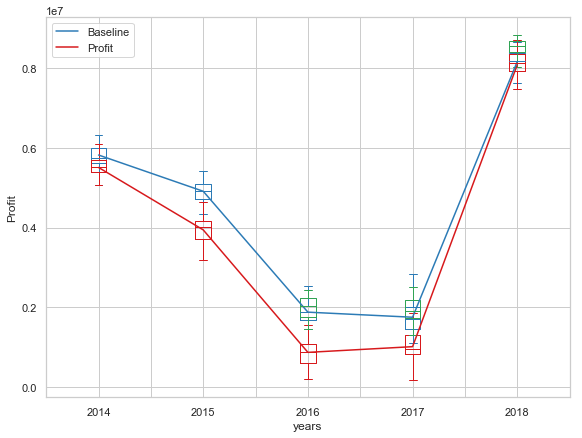

In [75]:
# cost blue red green
ee=[]
for i in cost_onnew:
    e = sum(i)/25
    ee.append(e)
eee=[]
for i in cost_new_b:
    e = sum(i)/25
    eee.append(e)
    
ticks = ["",2014,"",2015,"",2016,"",2017,"",2018]
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
plt.figure(figsize=(8,6))
bpl = plt.boxplot(cost_onnew, positions=[2,6,10,14,18], sym='', widths=0.6)
bpr = plt.boxplot(cost_new_b, positions=[2,6,10,14,18], sym='', widths=0.6)
#bpg = plt.boxplot(aucs_new_g, positions=[10,14,18])
set_box_color(bpl, '#2C7BB6') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#D7191C')

bp3 = plt.boxplot(cost_new_g, positions=[10,14,18], sym='', widths=0.6)
set_box_color(bp3,'#31a354')

#bp4 = plt.boxplot(aucs_new_p, positions=[10,14,18], sym='', widths=0.6)
#set_box_color(bp3,'#756bb1')


# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#2C7BB6', label='Baseline')
plt.plot([], c='#D7191C', label='Profit')

#plt.plot([], c='#31a354', label='Updated Models')

#plt.plot([6,10,14,18],ee,"-",color = '#31a354')
#plt.plot([10,14,18],eee,"-",color = '#756bb1')
plt.plot([2,6,10,14,18],eee,"-",color = '#D7191C')
plt.plot([2,6,10,14,18],ee,"-",color = "#2C7BB6")
plt.legend()
plt.xticks(range(0, len(ticks) *2+1, 2), ticks)
#plt.xlim(-2, len(ticks)*2)
#plt.ylim(0, 8)
plt.tight_layout()
plt.xlabel('years'); plt.ylabel('Profit');
#plt.savefig('aucbaseline.png',bbox_inches='tight')

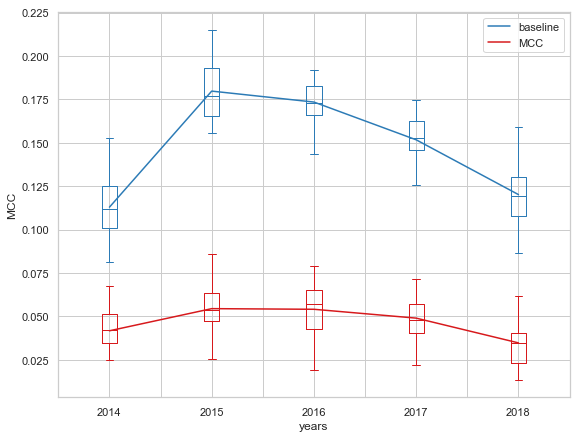

In [163]:
ee=[]
for i in mcc_onnew:
    e = sum(i)/25
    ee.append(e)
eee=[]
for i in mcc_new_b:
    e = sum(i)/25
    eee.append(e)

ticks = ["",2014,"",2015,"",2016,"",2017,"",2018]

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure(figsize=(8,6))

bpl = plt.boxplot(mcc_onnew, positions=[2,6,10,14,18], sym='', widths=0.6)
bpr = plt.boxplot(mcc_new_b, positions=[2,6,10,14,18], sym='', widths=0.6)
#bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#2C7BB6') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#D7191C')

#bp3 = plt.boxplot(aucs_new_g, positions=[6,10,14,18], sym='', widths=0.6)
#set_box_color(bp3,'#31a354')

#bp4 = plt.boxplot(aucs_new_p, positions=[10,14,18], sym='', widths=0.6)
#set_box_color(bp3,'#756bb1')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#2C7BB6', label='baseline')
plt.plot([], c='#D7191C', label='MCC')

#plt.plot([], c='#31a354', label='Updated Models')

#plt.plot([6,10,14,18],ee,"-",color = '#31a354')
#plt.plot([10,14,18],eee,"-",color = '#756bb1')
plt.plot([2,6,10,14,18],eee,"-",color = '#D7191C')
plt.plot([2,6,10,14,18],ee,"-",color = "#2C7BB6")
plt.legend()
plt.xticks(range(0, len(ticks) *2+1, 2), ticks)
#plt.xlim(-2, len(ticks)*2)
#plt.ylim(0, 8)
plt.tight_layout()
plt.xlabel('years'); plt.ylabel('MCC');
plt.savefig('MCCbaseline.png',bbox_inches='tight')

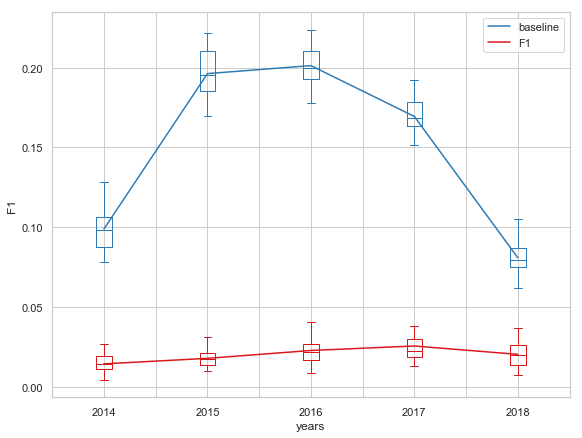

In [146]:
ee=[]
for i in f1_onnew:
    e = sum(i)/25
    ee.append(e)
eee=[]
for i in f1_new_b:
    e = sum(i)/25
    eee.append(e)

ticks = ["",2014,"",2015,"",2016,"",2017,"",2018]

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure(figsize=(8,6))

bpl = plt.boxplot(f1_onnew, positions=[2,6,10,14,18], sym='', widths=0.6)
bpr = plt.boxplot(f1_new_b, positions=[2,6,10,14,18], sym='', widths=0.6)
#bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#2C7BB6') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#D7191C')

#bp3 = plt.boxplot(aucs_new_g, positions=[6,10,14,18], sym='', widths=0.6)
#set_box_color(bp3,'#31a354')

#bp4 = plt.boxplot(aucs_new_p, positions=[10,14,18], sym='', widths=0.6)
#set_box_color(bp3,'#756bb1')


# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#2C7BB6', label='baseline')
plt.plot([], c='#D7191C', label='F1')

#plt.plot([], c='#31a354', label='Updated Models')

#plt.plot([6,10,14,18],ee,"-",color = '#31a354')
#plt.plot([10,14,18],eee,"-",color = '#756bb1')
plt.plot([2,6,10,14,18],eee,"-",color = '#D7191C')
plt.plot([2,6,10,14,18],ee,"-",color = "#2C7BB6")
plt.legend()
plt.xticks(range(0, len(ticks) *2+1, 2), ticks)
#plt.xlim(-2, len(ticks)*2)
#plt.ylim(0, 8)
plt.tight_layout()
plt.xlabel('years'); plt.ylabel('F1');
plt.savefig('f1 baseline.png',bbox_inches='tight')

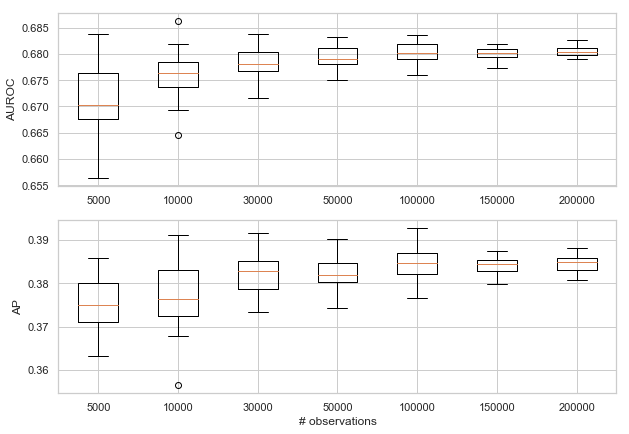

In [185]:
# Create a figure instance
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 7))

# Create the boxplot
ax1.boxplot(aucs)
#ax2.boxplot(mccs)
#ax3.boxplot(accuracys_all) 
ax2.boxplot(aps) 
#ax5.boxplot(f1s) 
#ax6.boxplot(precisions) 
#ax7.boxplot(recalls) 


#ax3.plot(rows,ave_times,"-o")
## Custom x-axis labels
ax2.set_xticklabels(obse)
ax1.set_xticklabels(obse)
#ax2.set_xticklabels(obse)
# Save the figure

#fig.savefig('fig1.png', bbox_inches='tight')
#f, ax = plt.subplots(figsize=(5,4), dpi=125)
#ax.plot(rows, aucs, label='Random Forest (sklearn)')
ax2.set_xlabel('# observations'); ax1.set_ylabel('AUROC');ax2.set_ylabel('AUPRC');
ax1.set_xlabel('');
#ax3.set_ylabel("RF average run time");


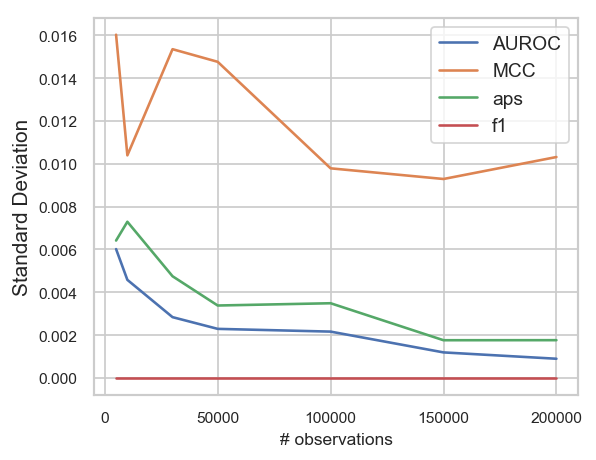

In [187]:
stds1 =[]
stds2 =[]
stds4 =[]
stds5 = []
for i in np.arange(len(aucs)):
    std1 = np.std(aucs[i])
    stds1.append(std1)
    
    std2 = np.std(mccs[i])
    stds2.append(std2)
    
    
    std4 = np.std(aps[i])
    stds4.append(std4)
    
    std5 = np.std(f1s[i])
    stds5.append(std5)
   
    
fig,ax =plt.subplots(figsize=(5,4), dpi=125)
ax.plot(obse,stds1,"-",label = "AUROC")
ax.plot(obse,stds2,"-",label = "MCC")
#ax.plot(obse,stds3,"-",label = "Accuracy")
ax.plot(obse,stds4,"-",label = "aps")
ax.plot(obse,stds5,"-",label = "f1")
#ax.plot(obse,stds6,"-",label = "precision")
#ax.plot(obse,stds7,"-",label = "recall")

ax.xaxis.label.set_fontsize(10)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(9)
ax.set_xlabel("# observations");ax.set_ylabel('Standard Deviation');ax.legend();
fig.savefig('pic4 std.png', bbox_inches='tight')

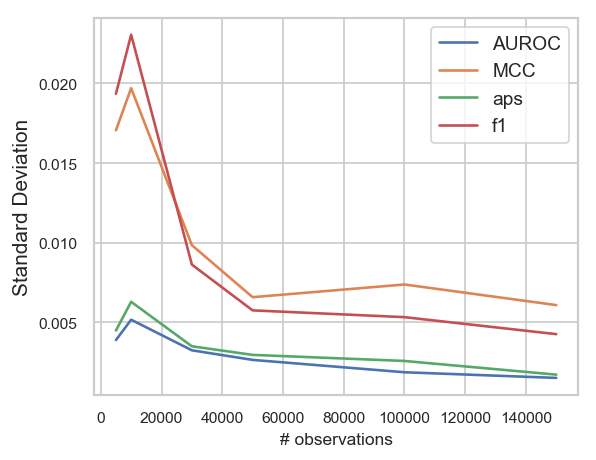

In [79]:
stds1 =[]
stds2 =[]
stds3 =[]
stds4 =[]
stds5 =[]
stds6 =[]
stds7 =[]
for i in np.arange(len(aucs_all)):
    std1 = np.std(aucs_all[i])
    stds1.append(std1)
    
    std2 = np.std(mccs_all[i])
    stds2.append(std2)
    
    std3 = np.std(accuracys_all[i])
    stds3.append(std3)
    
    std4 = np.std(aps_all[i])
    stds4.append(std4)
    
    std5 = np.std(f1s[i])
    stds5.append(std5)
    std6 = np.std(precisions[i])
    stds6.append(std6)
    std7 = np.std(recalls[i])
    stds7.append(std7)
    
fig,ax =plt.subplots(figsize=(5,4), dpi=125)
ax.plot(obse,stds1,"-",label = "AUROC")
ax.plot(obse,stds2,"-",label = "MCC")
#ax.plot(obse,stds3,"-",label = "Accuracy")
ax.plot(obse,stds4,"-",label = "aps")
ax.plot(obse,stds5,"-",label = "f1")
#ax.plot(obse,stds6,"-",label = "precision")
#ax.plot(obse,stds7,"-",label = "recall")

ax.xaxis.label.set_fontsize(10)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(9)
ax.set_xlabel("# observations");ax.set_ylabel('Standard Deviation');ax.legend();
fig.savefig('pic4 std.png', bbox_inches='tight')

In [77]:
a = [1,2,3,4]
np.mean(a)

2.5

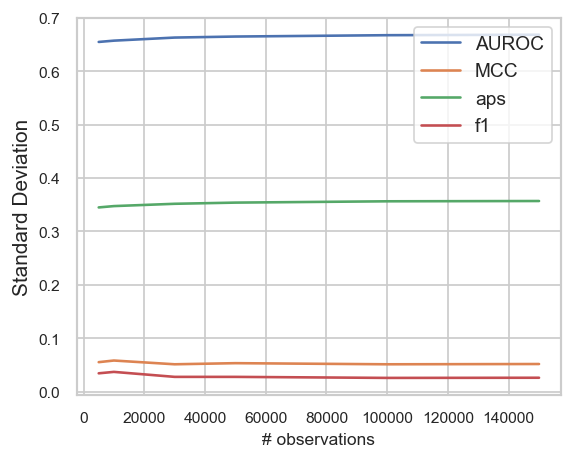

In [103]:
stds1 =[]
stds2 =[]
stds3 =[]
stds4 =[]
stds5 =[]
stds6 =[]
stds7 =[]
for i in np.arange(len(aucs_all)):
    std1 = np.mean(aucs_all[i])
    stds1.append(std1)
    
    std2 = np.mean(mccs_all[i])
    stds2.append(std2)
    
    std3 = np.mean(accuracys_all[i])
    stds3.append(std3)
    
    std4 = np.mean(aps_all[i])
    stds4.append(std4)
    
    std5 = np.mean(f1s[i])
    stds5.append(std5)
    std6 = np.mean(precisions[i])
    stds6.append(std6)
    std7 = np.mean(recalls[i])
    stds7.append(std7)
    
fig,ax =plt.subplots(figsize=(5,4), dpi=125)
ax.plot(obse,stds1,"-",label = "AUROC")
ax.plot(obse,stds2,"-",label = "MCC")
#ax.plot(obse,stds3,"-",label = "Accuracy")
ax.plot(obse,stds4,"-",label = "aps")
ax.plot(obse,stds5,"-",label = "f1")
#ax.plot(obse,stds6,"-",label = "precision")
#ax.plot(obse,stds7,"-",label = "recall")

ax.xaxis.label.set_fontsize(10)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(9)
ax.set_xlabel("# observations");ax.set_ylabel('Standard Deviation');ax.legend();
fig.savefig('pic4 std.png', bbox_inches='tight')

In [234]:
###run the model with different number of features and see how the std changes
# Create a figure instance
fig, (ax1, ax2,ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 11))

# Create the boxplot
ax1.boxplot(aucs)
ax2.boxplot(mccs)
ax3.boxplot(accuracys) 
#ax3.plot(rows,ave_times,"-o")
## Custom x-axis labels
ax3.set_xticklabels(obse)
ax1.set_xticklabels(obse)
ax2.set_xticklabels(obse)
# Save the figure
#fig.savefig('fig1.png', bbox_inches='tight')
#f, ax = plt.subplots(figsize=(5,4), dpi=125)
#ax.plot(rows, aucs, label='Random Forest (sklearn)')
ax3.set_xlabel('# observations'); ax1.set_ylabel('AUROC');ax2.set_ylabel('MCC');ax3.set_ylabel('Accuracy')
ax1.set_xlabel('');
#ax3.set_ylabel("RF average run time");


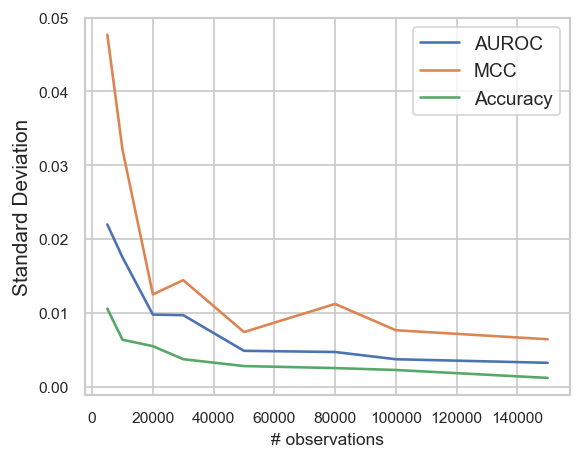

In [252]:
stds1 =[]
stds2 =[]
std_acc =[]
for i in np.arange(len(aucs)):
    std1 = np.std(aucs[i])
    stds1.append(std1)
    std2 = np.std(mccs[i])
    stds2.append(std2)
    std3 = np.std(accuracys[i])
    std_acc.append(std3)
fig,ax =plt.subplots(figsize=(5,4), dpi=125)
ax.plot(obse,stds1,"-",label = "AUROC")
ax.plot(obse,stds2,"-",label = "MCC")
ax.plot(obse,std_acc,"-",label = "Accuracy")
ax.xaxis.label.set_fontsize(10)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(9)
ax.set_xlabel("# observations");ax.set_ylabel('Standard Deviation');ax.legend();
fig.savefig('pic4 std.png', bbox_inches='tight')

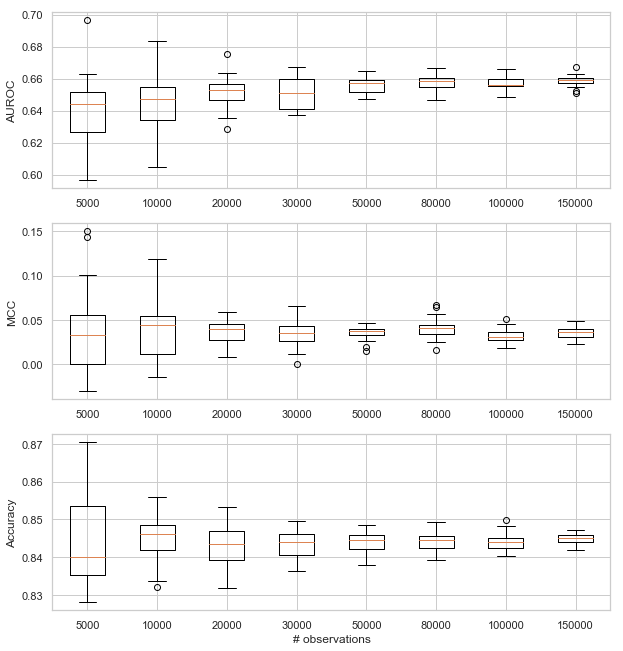

In [240]:
# Create a figure instance
fig, (ax1, ax2,ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 11))

# Create the boxplot
ax1.boxplot(aucs)
ax2.boxplot(mccs)
ax3.boxplot(accuracys) 
#ax3.plot(rows,ave_times,"-o")
## Custom x-axis labels
ax3.set_xticklabels(obse)
ax1.set_xticklabels(obse)
ax2.set_xticklabels(obse)
# Save the figure
#fig.savefig('fig1.png', bbox_inches='tight')
#f, ax = plt.subplots(figsize=(5,4), dpi=125)
#ax.plot(rows, aucs, label='Random Forest (sklearn)')
ax3.set_xlabel('# observations'); ax1.set_ylabel('AUROC');ax2.set_ylabel('MCC');ax3.set_ylabel('Accuracy')
ax1.set_xlabel('');
#ax3.set_ylabel("RF average run time");


In [241]:
fig.savefig('pic4 #150000 with cv.png', bbox_inches='tight')

In [636]:
data15= data[data["issue_d"]==2015]

In [637]:
def frf_observation(row_num):
    aucs_all = []
    accuracys_all =[]
    mccs_all =[]
    for i in np.arange(5):
        df = olddata.sample(row_num)
        auc,accuracy,mcc = cv(df,5)
        aucs_all += auc
        accuracys_all += accuracy
        mccs_all += mcc
    return aucs_all,accuracys_all,mccs_all


In [823]:
olddata.shape

(227957, 23)

In [641]:
#aucs_2014 = aucs
#aucs_2015 =aucs
#mccs_2015 = mccs
#accs_2015 = accuracys

In [639]:
obse = [5000,10000,30000,50000,100000,150000,200000]
#rows = [6250,12500,25000,37500,62500,100000,125000,187500]

aucs = []
accuracys =[]
mccs=[]
#ave_times = []
for row_num in obse:
 #   start_time = time.time()
    aucs_all,accuracys_all,mccs_all= frf_observation(row_num)
  #  ave_time = (time.time() - start_time)/25
    #print("--- %s seconds ---" %ave_time)
    aucs.append(aucs_all)
    #mse.append(mses_all)
    accuracys.append(accuracys_all)
    #F1.append(F1s_all)
    #precision.append(precisions_all)
    #recall.append(recalls_all)
    mccs.append(mccs_all)
    #ave_times.append(ave_time)
    

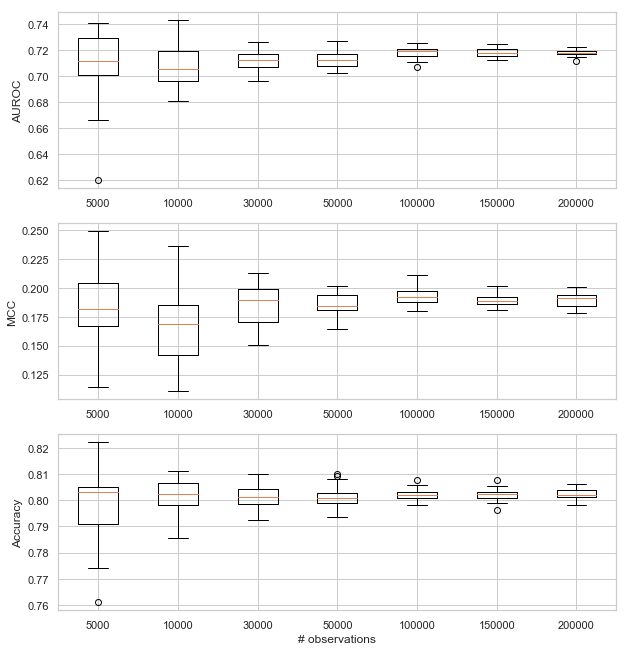

In [640]:
# Create a figure instance
fig, (ax1, ax2,ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 11))

# Create the boxplot
ax1.boxplot(aucs)
ax2.boxplot(mccs)
ax3.boxplot(accuracys) 

ax3.set_xticklabels(obse)
ax1.set_xticklabels(obse)
ax2.set_xticklabels(obse)

#ax.plot(rows, aucs, label='Random Forest (sklearn)')
ax3.set_xlabel('# observations'); ax1.set_ylabel('AUROC');ax2.set_ylabel('MCC');ax3.set_ylabel('Accuracy')
ax1.set_xlabel('');
#ax3.set_ylabel("RF average run time");
fig.savefig('pic4-2  #200000 with cv.png', bbox_inches='tight')

In [273]:
def plot_var(col_name, full_name,loans, continuous):
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if continuous:
        sns.distplot(loans.loc[loans[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(loans[col_name], order=sorted(loans[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='y', data=loans,orient = "h")
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        charge_off_rates = loans.groupby(col_name)['y'].value_counts(normalize=True).loc[:,1]
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged-off')
        ax2.set_title('Charge-off Rate by ' + full_name)
    ax2.set_xlabel(full_name)

    plt.tight_layout()

In [ ]:
plot_var("int_rate", "Interest rate", savebig, continuous = True)
plot_var("int_rate", "Interest rate", savedata, continuous = True)
plot_var("sub_grade", "subgrade", savebig, continuous = False)
plot_var("sub_grade", "subgrade", savedata, continuous = False)

In [ ]:

plot_var("dti", "dti", savebig, continuous = True)
#savedata = savedata[savedata["dti"] < 200]
plot_var("dti", "dti", savedata, continuous = True)

In [ ]:
def cv(data,k):
    fold = KFold(k)
    aucs = []
    #mses = []
    accuracys =[]
    
    #F1s =[]
    #precisions=[]
    #recalls=[]
    mccs=[]
    for train_idx, vali_idx in fold.split(data): 
        cv_train,cv_validate=data.iloc[train_idx,:], data.iloc[vali_idx,:]
        X_train = cv_train[cv_train.columns[:-1]]
        y_train = cv_train[cv_train.columns[-1]]
        X_test = cv_validate[cv_validate.columns[:-1]]
        y_test = cv_validate[cv_validate.columns[-1]]
        criterion = "gini"
        auc,accuracy,mcc = rf(X_train, X_test, y_train, y_test,criterion)
        aucs.append(auc)
        #mses.append(mse)
        accuracys.append(accuracy)
        #F1s.append(F1)
        #precisions.append(precision)
        #recalls.append(recall)
        mccs.append(mcc)
        
    #mean_auc = round(np.mean(aucs),3)    
    
    return aucs,accuracys,mccs#,F1s

In [799]:
olddata.shape[0]/5

45591.4

In [ ]:
 # test different size of test set  ,auroc, same model test on different size of test data will result in converge
aucst = []
aucs_newt=[[],[],[],[]]
count = 0
traindata = olddata.sample(50000)
fold = KFold(10,shuffle = True)  
print(i)
for train_idx, vali_idx in fold.split(traindata): 
    cv_train,cv_validate=traindata.iloc[train_idx,:], traindata.iloc[vali_idx,:]
    X_train = cv_train[cv_train.columns[:-1]]
    y_train = cv_train[cv_train.columns[-1]]
    X_test = cv_validate[cv_validate.columns[:-1]]
    y_test = cv_validate[cv_validate.columns[-1]]
    criterion = "gini"
    forest = RandomForestClassifier(n_estimators=150, max_features ="sqrt", n_jobs = -1,criterion=criterion)
    forest.fit(X_train, y_train)
    auc = metrics.roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1]) 
    aucst.append(auc)
    for year in [5000,10000,15000,20000]:
        
        testdata = data[data["issue_d"] == 2015].sample(year)
        X_test = testdata[testdata.columns[:-1]]
        y_test = testdata[testdata.columns[-1]]
        auc_ = metrics.roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1]) 
        #accuracy_ = metrics.accuracy_score(y_test, forest.predict(X_test))
            #mcc_ = metrics.matthews_corrcoef(y_test, forest.predict(X_test))
        aucs_newt[int((year-5000)/5000)].append(auc_)
      

In [854]:
aucs = []  # 5 folds  *5 test on 50000  original model
#accuracys =[]
#mccs=[]
aucs_new = [[],[],[],[],[]]    

for i in np.arange(5):
    traindata = olddata
    fold = KFold(5,shuffle = True)  
    print(i)
    for train_idx, vali_idx in fold.split(traindata): 
        cv_train,cv_validate=traindata.iloc[train_idx,:], traindata.iloc[vali_idx,:]
        X_train = cv_train[cv_train.columns[:-1]]
        y_train = cv_train[cv_train.columns[-1]]
        X_test = cv_validate[cv_validate.columns[:-1]]
        y_test = cv_validate[cv_validate.columns[-1]]
        criterion = "gini"
        forest = RandomForestClassifier(n_estimators=150, max_features ="sqrt",min_samples_leaf =30, n_jobs = -1,criterion=criterion)
        forest.fit(X_train, y_train)
        auc = metrics.roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1]) 
        aucs.append(auc)
        for year in [0,1,2,3,4]:
            testdata = data[data["issue_d"] == (year+2014)].sample(45000)
            X_test = testdata[testdata.columns[:-1]]
            y_test = testdata[testdata.columns[-1]]
            auc_ = metrics.roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1]) 
            #accuracy_ = metrics.accuracy_score(y_test, forest.predict(X_test))
            #mcc_ = metrics.matthews_corrcoef(y_test, forest.predict(X_test))
            aucs_new[year].append(auc_)

0
1
2
3
4


In [845]:
aucs_new.insert(0,aucs)

In [ ]:
fig = plt.figure(1, figsize=(8, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(aucs_new)

ax.plot()
## Custom x-axis labels
ax.set_xticklabels(["2007-2013",2014,2015,2016,2017,2018])

ax.set_xlabel('years - trained one past data'); ax.set_ylabel('AUROC');
fig.savefig('folds55  on test on the same.png', bbox_inches='tight')

In [857]:
#mccs=[]
# baseline model
aucs_onnew = [[],[],[],[],[]] 
for year in [0,1,2,3,4]: 
    print(year)
    for i in np.arange(5):
        traindata = data[data["issue_d"] <= (year+2014)].sample(225000)
        fold = KFold(5,shuffle = True)  
        for train_idx, vali_idx in fold.split(traindata): 
            cv_train,cv_validate=traindata.iloc[train_idx,:], traindata.iloc[vali_idx,:]
            X_train = cv_train[cv_train.columns[:-1]]
            y_train = cv_train[cv_train.columns[-1]]
            X_test = cv_validate[cv_validate.columns[:-1]]
            y_test = cv_validate[cv_validate.columns[-1]]
            criterion = "gini"
            forest = RandomForestClassifier(n_estimators=150, max_features ="sqrt", min_samples_leaf =30,n_jobs = -1,criterion=criterion)
            forest.fit(X_train, y_train)
            auc = metrics.roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1]) 
            aucs_onnew[year].append(auc)

0
1
2
3
4


In [852]:
olddata.shape

(227957, 23)

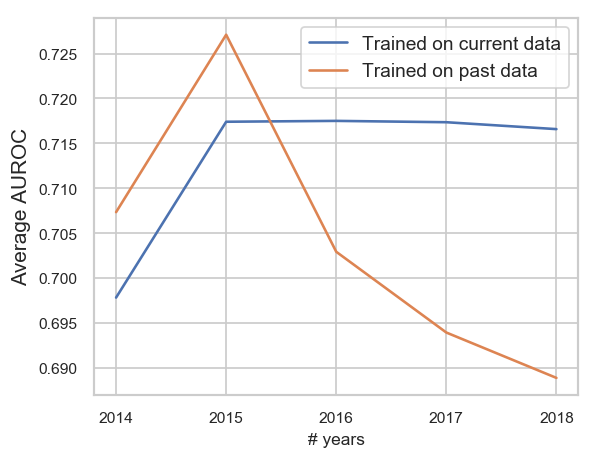

In [864]:
ave1 =[]
ave2 =[]

for i in np.arange(len(aucs_new)):
    ave = sum(aucs_new[i])/len(aucs_new[i])
    ave1.append(ave)
    aver = sum(aucs_onnew[i])/len(aucs_onnew[i])
    ave2.append(aver)
    
year = [2014,2015,2016,2017,2018]
fig,ax =plt.subplots(figsize=(5,4), dpi=125)
ax.plot(year,ave2,"-",label = "Trained on current data")
#ax.boxplot(year,aucs_new_g,positions= [2,3,4])
ax.plot(year,ave1,"-",label = "Trained on past data")

ax.xaxis.label.set_fontsize(10)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(9)
ax.set_xlabel("# years");ax.set_ylabel('Average AUROC');ax.legend();
fig.savefig('line on past current.png', bbox_inches='tight')

In [ ]:
aucs_old = []  # 25 times split and with 30000 ,test on all data 
#accuracys =[]
#mccs=[]
aucs_new = [[],[],[],[],[]]  # contains the 6*5 data points from the first model    
#accuracys_new =[[],[],[],[],[]]
#mccs_new = [[],[],[],[],[]]
for i in np.arange(25):
    print(i)
    traindata = olddata
    X_train, X_test, y_train, y_test = split_(traindata[traindata.columns[:-1]],traindata[traindata.columns[-1]])
    criterion = "gini"
    forest = RandomForestClassifier(n_estimators=100, max_features = "sqrt",n_jobs = -1, criterion=criterion)
    forest.fit(X_train, y_train)
    auc = metrics.roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1]) 
        #accuracy  = metrics.accuracy_score(y_test, forest.predict(X_test))            
        #mcc = metrics.matthews_corrcoef(y_test, forest.predict(X_test))
        #print(auc)
    aucs_old.append(auc)
        #accuracys.append(accuracy)
        #mccs.append(mcc)
    for year in [0,1,2,3,4]:
        testdata = data[(data["issue_d"] == year+2014 )]
        X_test = testdata[testdata.columns[:-1]]
        y_test = testdata[testdata.columns[-1]]
        auc_ = metrics.roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1]) 
            #accuracy_ = metrics.accuracy_score(y_test, forest.predict(X_test))
            #mcc_ = metrics.matthews_corrcoef(y_test, forest.predict(X_test))
        aucs_new[year].append(auc_)
            #accuracys_new[year].append(accuracy_)
            #mccs_new[year].append(mcc_)      



In [663]:
aucs_new.insert(0,aucs_old)
#accuracys_new.insert(0,accuracys)
#mccs_new.insert(0,mccs)

In [747]:
data[(data["issue_d"] == 2018 )].shape

(56149, 23)

In [353]:
#aucs_3w = aucs_new
#aucs_5k = aucs_new
aucs_10k = aucs_new


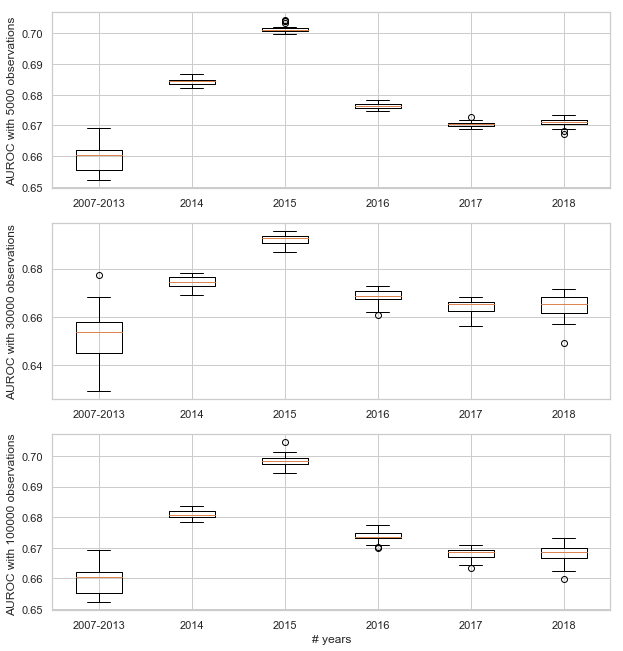

In [647]:
# Create a figure instance
fig, (ax1, ax2,ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 11))

# Create the boxplot
ax1.boxplot(aucs_new)
ax2.boxplot(aucs_3w)
ax3.boxplot(aucs_10k) 

#ax3.set_xticklabels(obse)
#ax1.set_xticklabels(obse)
#ax2.set_xticklabels(obse)

#ax.plot(rows, aucs, label='Random Forest (sklearn)')
ax3.set_xlabel('# years'); ax1.set_ylabel('AUROC with 5000 observations');
ax2.set_ylabel('AUROC with 30000 observations');ax3.set_ylabel('AUROC with 100000 observations ');
ax1.set_xlabel('');
ax1.set_xticklabels(["2007-2013",2014,2015,2016,2017,2018])
ax2.set_xticklabels(["2007-2013",2014,2015,2016,2017,2018])
ax3.set_xticklabels(["2007-2013",2014,2015,2016,2017,2018])

#ax1.annotate('with 5000 observations from 2007-2013 for training',xy = (2017,0.62))
#ax3.set_ylabel("RF average run time");
fig.savefig('all all.png', bbox_inches='tight')


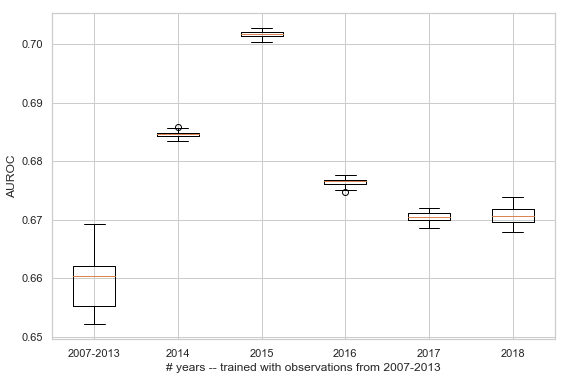

In [690]:
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(aucs_new)

ax.plot()
## Custom x-axis labels
ax.set_xticklabels(["2007-2013",2014,2015,2016,2017,2018])

ax.set_xlabel('# years -- trained with observations from 2007-2013'); ax.set_ylabel('AUROC');
#fig.savefig('all with 10folds.png', bbox_inches='tight')

In [820]:
data["y"].value_counts()[1]/data["y"].value_counts()[0]

0.2493740471348314

ValueError: List of boxplot statistics and `positions` values must have same the length

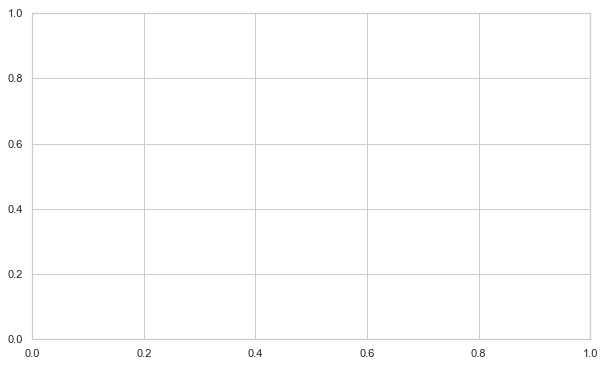

In [858]:
import matplotlib.pyplot as plt
import numpy as np

data_a = aucs_new[1:]
data_b = aucs_onnew

ticks = ["",2014,"",2015,"",2016,"",2017,"",2018]

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure(figsize=(10,6))

bpl = plt.boxplot(data_a, positions=[2,6,10,14,18], sym='', widths=0.6)
bpr = plt.boxplot(data_b, positions=[2,6,10,14,18], sym='', widths=0.6)
#bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#2C7BB6', label='Baseline Models')
plt.plot([], c='#D7191C', label='Original Models')

plt.plot([2,6,10,14,18],ave2,"-")
plt.plot([2,6,10,14,18],ave1,"-")
plt.legend()
plt.xticks(range(0, len(ticks) *2+1, 2), ticks)
#plt.xlim(-2, len(ticks)*2)
#plt.ylim(0, 8)
plt.tight_layout()
plt.xlabel('years'); plt.ylabel('AUROC');

plt.savefig('new boxcompare2.png',bbox_inches='tight')

In [719]:
A

[[0.6837291311325089,
  0.6845891161488321,
  0.6838895615363393,
  0.685036035835692,
  0.6842203144859877,
  0.6848120086839745,
  0.6842783774242844,
  0.6850089954537208,
  0.6848637531152232,
  0.6843130279628421,
  0.6847478942347274,
  0.6853770407945365,
  0.6843414974649604,
  0.6844981624827154,
  0.6841202408901526,
  0.6845442251515473,
  0.6853641098777589,
  0.6840352931340027,
  0.6843311356929275,
  0.684198375605597,
  0.6846612233889837,
  0.6842771217614668,
  0.684595089610661,
  0.6844688949967618,
  0.6834470864431819,
  0.6837623868017315,
  0.6847708671157591,
  0.6845290499719978,
  0.6855674052732273,
  0.6838595432031453,
  0.684615294986006,
  0.6846850911309044,
  0.6846012606322431,
  0.6850029674443021,
  0.6853228396520088,
  0.6846470940943725,
  0.6841258293140984,
  0.6856857918369583,
  0.6841678610696031,
  0.6849333129094871,
  0.6845975867819643,
  0.6847290711099969,
  0.6844724345144204,
  0.6833675392990191,
  0.6853973925870963,
  0.6858620794

In [708]:
dd = pd.DataFrame(aucs_new[1:]).T
dd.columns = [2014,2015,2016,2017,2018]
dd2 = pd.DataFrame(new).T
dd2.columns = [2014,2015,2016,2017,2018]
boxdf = pd.concat([dd,dd2])
boxdf["h"] = ["trained on past years"]*50+["trained on current year"]*10
boxdf
import seaborn as sns

# Grouped boxplot
sns.boxplot(x="day", y="total_bill", hue="smoker", data=df, palette="Set1")
#sns.plt.show()


2014      2015      2016      2017      2018                        h
0   0.683729  0.702421  0.677169  0.670476  0.673645    trained on past years
1   0.684589  0.701618  0.676010  0.671440  0.672331    trained on past years
2   0.683890  0.701345  0.676161  0.669881  0.670024    trained on past years
3   0.685036  0.702448  0.677132  0.671074  0.671374    trained on past years
4   0.684220  0.701182  0.676792  0.671941  0.669543    trained on past years
5   0.684812  0.702385  0.676883  0.670608  0.670705    trained on past years
6   0.684278  0.701673  0.677533  0.671950  0.671320    trained on past years
7   0.685009  0.701998  0.676310  0.670054  0.671879    trained on past years
8   0.684864  0.700958  0.675566  0.670050  0.668769    trained on past years
9   0.684313  0.701668  0.675938  0.669792  0.671617    trained on past years
10  0.684748  0.701468  0.676266  0.670003  0.668480    trained on past years
11  0.685377  0.702349  0.676760  0.670610  0.669772    trained on past years
12  0.684341  0.702028  0.676649  0.670331  0.672149    trained on past years
13  0.684498  0.701746  0.676534  0.671279  0.669654    trained on past years
14  0.684120  0.701771  0.676992  0.670142  0.672108    trained on past years
15  0.684544  0.702763  0.677290  0.671610  0.671557    trained on past years
16  0.685364  0.701572  0.676544  0.670911  0.670419    trained on past years
17  0.684035  0.701411  0.676797  0.671229  0.669928    trained on past years
18  0.684331  0.701046  0.676017  0.668507  0.668174    trained on past years
19  0.684198  0.700950  0.675387  0.670907  0.671580    trained on past years
20  0.684661  0.701496  0.676562  0.671107  0.670725    trained on past years
21  0.684277  0.701647  0.676141  0.669795  0.671719    trained on past years
22  0.684595  0.701591  0.674780  0.668629  0.668853    trained on past years
23  0.684469  0.701633  0.677468  0.671192  0.671790    trained on past years
24  0.683447  0.702467  0.676735  0.670774  0.671265    trained on past years
25  0.683762  0.702334  0.676235  0.670597  0.669607    trained on past years
26  0.684771  0.702171  0.677205  0.670114  0.668190    trained on past years
27  0.684529  0.701412  0.676084  0.668712  0.671201    trained on past years
28  0.685567  0.702601  0.676593  0.670205  0.672575    trained on past years
29  0.683860  0.701861  0.676421  0.671165  0.669760    trained on past years
30  0.684615  0.701898  0.675801  0.669538  0.668675    trained on past years
31  0.684685  0.701734  0.676085  0.670256  0.670349    trained on past years
32  0.684601  0.701797  0.676880  0.671103  0.672490    trained on past years
33  0.685003  0.701449  0.675721  0.669850  0.672290    trained on past years
34  0.685323  0.700899  0.676642  0.670050  0.673281    trained on past years
35  0.684647  0.701002  0.676619  0.671263  0.670233    trained on past years
36  0.684126  0.700762  0.675393  0.670402  0.673467    trained on past years
37  0.685686  0.702188  0.677638  0.670828  0.670550    trained on past years
38  0.684168  0.700911  0.676056  0.669964  0.670328    trained on past years
39  0.684933  0.701311  0.675033  0.669143  0.671476    trained on past years
40  0.684598  0.701094  0.676160  0.670087  0.670462    trained on past years
41  0.684729  0.701440  0.676947  0.669977  0.668679    trained on past years
42  0.684472  0.701263  0.676728  0.670438  0.669254    trained on past years
43  0.683368  0.700386  0.675321  0.669372  0.671407    trained on past years
44  0.685397  0.702504  0.676603  0.671795  0.673908    trained on past years
45  0.685862  0.702577  0.676821  0.670503  0.669157    trained on past years
46  0.684357  0.701840  0.677394  0.671293  0.671907    trained on past years
47  0.684668  0.701325  0.675256  0.668789  0.669310    trained on past years
48  0.684904  0.701909  0.676597  0.669130  0.667964    trained on past years
49  0.684958  0.702141  0.676465  0.670824  0.671392    trained on past years
0   0.699404  0.720479  0.7034

In [331]:
data["issue_d"].value_counts()

2015    375537
2016    293017
2014    223102
2017    169013
2013    134804
2018     56149
2012     53367
2011     21721
2010     11536
2009      4716
2008      1562
2007       251
Name: issue_d, dtype: int64

In [394]:
a = data[data["issue_d"]==2018]["y"].value_counts()
a[1]/(a[0]+a[1])

0.15729576662095496

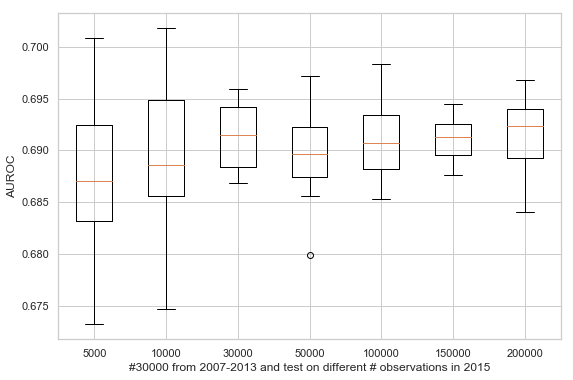

In [396]:
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(aucs_2015)

ax.plot()
## Custom x-axis labels
ax.set_xticklabels([5000,10000,30000,50000,100000,150000,200000])

ax.set_xlabel('#30000 from 2007-2013 and test on different # observations in 2015'); ax.set_ylabel('AUROC');
fig.savefig('pic 6-2#30000 from 2007-2013 and test on different # observations in 2015.png', bbox_inches='tight')

In [315]:
stds_3w=[]
for i in np.arange(6):
    std = np.std(aucs_new[i])
    stds_3w.append(std)

/Users/hui/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hui/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hui/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
d2015 = data[data["issue_d"]==2015]
d2016 = data[data["issue_d"]==2016]
plot_var("dti", "subgrade-2016", d2016, continuous = True)
plot_var("dti", "subgrade-2015", d2015, continuous = True)

In [521]:
pip install treeinterpreter

Note: you may need to restart the kernel to use updated packages.


In [522]:
from treeinterpreter import treeinterpreter as ti

In [547]:
smalldata = newdata.sample(10000)
X_train, X_test, y_train, y_test = split_(smalldata[smalldata.columns[:-1]],smalldata[smalldata.columns[-1]])
forest = RandomForestClassifier(n_estimators=200, max_features = "sqrt",min_samples_leaf = 30 ,
                                min_samples_split = 40,criterion=criterion)
forest.fit(X_train, y_train)
prediction, bias, contributions = ti.predict(forest, X_test.iloc[[2,4],:])
print(prediction)
for c, feature in zip(contributions[0], data.columns):
    print (feature, c)

[[0.94995058 0.05004942]
 [0.95341474 0.04658526]]
term [ 0.01304639 -0.01304639]
sub_grade [ 0.03765565 -0.03765565]
home_ownership [ 0.00482901 -0.00482901]
verification_status [ 0.00492818 -0.00492818]
purpose [ 0.00021487 -0.00021487]
addr_state [-0.00046001  0.00046001]
initial_list_status [-0.00033263  0.00033263]
application_type [ 0.00012249 -0.00012249]
loan_amnt [-0.00166538  0.00166538]
int_rate [ 0.03864357 -0.03864357]
installment [ 0.00410071 -0.00410071]
issue_d [-0.00896699  0.00896699]
dti [ 0.01176469 -0.01176469]
earliest_cr_line [ 0.00303938 -0.00303938]
emp_length [ 0.00193293 -0.00193293]
open_acc [-0.00441955  0.00441955]
pub_rec [ 0.00151523 -0.00151523]
revol_util [ 0.00459059 -0.00459059]
total_acc [-0.00052519  0.00052519]
mort_acc [ 0.00582993 -0.00582993]
pub_rec_bankruptcies [ 0.00048395 -0.00048395]
fico_score [ 0.02598711 -0.02598711]


In [548]:
forest2 = RandomForestClassifier(n_estimators=200, max_features = "sqrt",min_samples_leaf = 30 ,
                                min_samples_split = 40,criterion=criterion)
forest2.fit(X_train, y_train);

In [549]:
prediction, bias, contributions = ti.predict(forest2, X_test.iloc[[2,4],:])
print(prediction)
for c, feature in zip(contributions[0], data.columns):
    print (feature, c)

[[0.94357174 0.05642826]
 [0.957441   0.042559  ]]
term [ 0.0131958 -0.0131958]
sub_grade [ 0.0393844 -0.0393844]
home_ownership [ 0.0042428 -0.0042428]
verification_status [ 0.00578088 -0.00578088]
purpose [ 0.0006719 -0.0006719]
addr_state [ 0.00116159 -0.00116159]
initial_list_status [-0.00045268  0.00045268]
application_type [ 4.89801151e-05 -4.89801151e-05]
loan_amnt [-0.00334557  0.00334557]
int_rate [ 0.03854388 -0.03854388]
installment [ 0.00321828 -0.00321828]
issue_d [-0.01271794  0.01271794]
dti [ 0.00756357 -0.00756357]
earliest_cr_line [ 0.00247131 -0.00247131]
emp_length [ 0.00265828 -0.00265828]
open_acc [-0.00677409  0.00677409]
pub_rec [ 0.00104061 -0.00104061]
revol_util [ 0.00670902 -0.00670902]
total_acc [-0.00090424  0.00090424]
mort_acc [ 0.00701423 -0.00701423]
pub_rec_bankruptcies [ 0.00103369 -0.00103369]
fico_score [ 0.02496328 -0.02496328]


In [529]:
print(prediction)

[[0.85256597 0.14743403]
 [0.73673588 0.26326412]
 [0.5788127  0.4211873 ]
 ...
 [0.8220876  0.1779124 ]
 [0.93076161 0.06923839]
 [0.89528669 0.10471331]]


In [535]:
for c, feature in zip(contributions[0], data.columns):
    print (feature, c)

term [ 0.01067179 -0.01067179]
sub_grade [ 0.02832584 -0.02832584]
home_ownership [-0.00486712  0.00486712]
verification_status [-0.0080711  0.0080711]
purpose [ 0.00287633 -0.00287633]
addr_state [-0.00096054  0.00096054]
initial_list_status [-0.00066733  0.00066733]
application_type [ 1.23490084e-05 -1.23490084e-05]
loan_amnt [-0.00038732  0.00038732]
int_rate [ 0.03058763 -0.03058763]
installment [-0.00930178  0.00930178]
issue_d [-0.02154843  0.02154843]
dti [ 0.02245275 -0.02245275]
earliest_cr_line [ 0.00580089 -0.00580089]
emp_length [-0.00753984  0.00753984]
open_acc [ 0.00344102 -0.00344102]
pub_rec [ 0.00250479 -0.00250479]
revol_util [-0.00802608  0.00802608]
total_acc [-0.00020335  0.00020335]
mort_acc [ 0.00741198 -0.00741198]
pub_rec_bankruptcies [ 0.00074859 -0.00074859]
fico_score [-0.00345385  0.00345385]


In [528]:
assert(np.allclose(prediction, bias + np.sum(contributions, axis=1)))
assert(np.allclose(forest.predict(X_test), bias + np.sum(contributions, axis=1)))

ValueError: operands could not be broadcast together with shapes (2000,) (2000,2) 

In [546]:
def Plot_predictor_importance(forest, data):
    feature_columns = data.columns
    feature_importances = forest.feature_importances_
    sorted_idx = np.argsort(-feature_importances)
    y_pos  = np.arange(sorted_idx.shape[0])
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    ax1.barh(y_pos, 
            feature_importances[sorted_idx], 
            align='center', 
            color='green', 
            ecolor='black', 
            height=0.7)
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(feature_columns[sorted_idx],fontsize = 10)
    ax1.invert_yaxis()
    ax1.set_xlabel('Relative Importance',fontsize = 15)
    ax1.set_title('Gini Importance',fontsize = 15)
    
    perm_imp_rfpimp = permutation_importances(forest, X_train, y_train, r2)

    ax2 .barh(np.arange(len(perm_imp_rfpimp.values)),np.ravel(perm_imp_rfpimp.values), align='center',color='green', 
            ecolor='black', height= 0.7)
    ax2.set_yticks(np.arange(len(perm_imp_rfpimp.values)))
    ax2.set_yticklabels(perm_imp_rfpimp.index.values,fontsize = 10)
    ax2.invert_yaxis()
    ax2.set_xlabel('Relative Importance',fontsize = 15)
    ax2.set_title('Permutation importance',fontsize = 15)
    plt.show()

array([0.01402195, 0.09778735, 0.02172457, 0.02580639, 0.09708008,
       0.12498942, 0.03029873, 0.13989848, 0.09559426, 0.08895347,
       0.13460993, 0.04817561, 0.08105976])

In [ ]:
def get_imp(forest,X_train, y_train)
    

In [407]:
# testing less features
data_i = olddata.drop(["application_type","pub_rec_bankruptcies","addr_state","total_acc","pub_rec",
              "purpose","emp_length","initial_list_status"],axis =1)

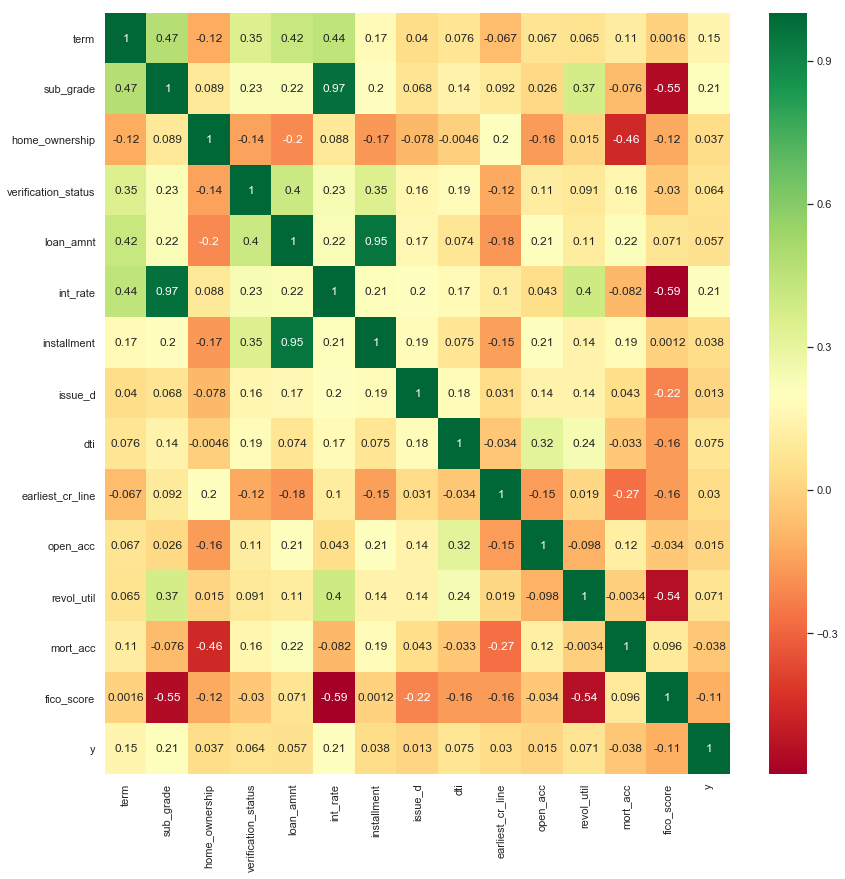

In [410]:
import seaborn as sns

#get correlations of each features in dataset
corrmat = data_i.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(14,14))
#plot heat map
g=sns.heatmap(data_i[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [414]:
pip install rfpimp

  Stored in directory: /Users/hui/Library/Caches/pip/wheels/c7/35/67/4065afd69df4c0be693ecdec8a9c1433a23f80ee60395272ba
  Stored in directory: /Users/hui/Library/Caches/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built rfpimp sklearn
Note: you may need to restart the kernel to use updated packages.


In [471]:
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

24
0.6538050397316759


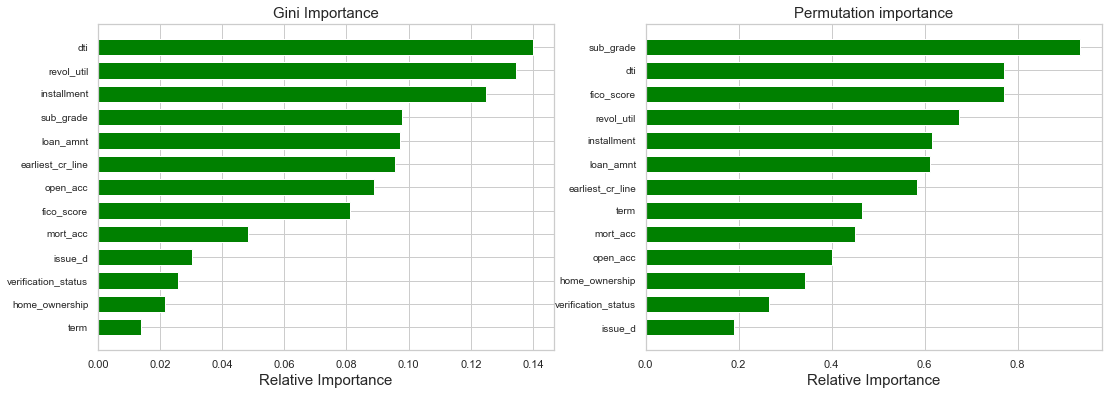

In [554]:
observations = 30000
#for i in np.arange(25):
print(i)
traindata = data_i.sample(observations).drop(["int_rate"],axis = 1)
X = traindata[traindata.columns[:-1]]
y = traindata[traindata.columns[-1]] 
X_train, X_test, y_train, y_test = split_(X,y)
criterion = "entropy"
forest = RandomForestClassifier(n_estimators=100, max_features = "sqrt",criterion=criterion)
forest.fit(X_train, y_train)
auc = metrics.roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1]) 
        #accuracy  = metrics.accuracy_score(y_test, forest.predict(X_test))            
        #mcc = metrics.matthews_corrcoef(y_test, forest.predict(X_test))
print(auc)
Plot_predictor_importance(forest,traindata) 

In [622]:
estimator = forest.estimators_[5]
detail = zip(traindata.columns[estimator.tree_.feature], estimator.tree_.threshold, estimator.tree_.children_left, estimator.tree_.children_right)
estimator.tree_.children_left

array([ 1,  2,  3, ..., -1, -1, -1])

24
0.6515764210337174


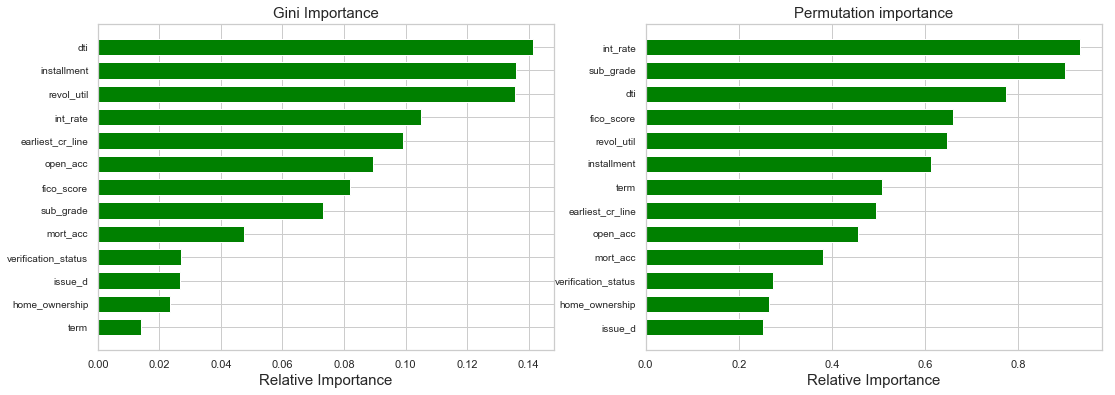

In [553]:
observations = 30000
#for i in np.arange(25):
print(i)
traindata = data_i.sample(observations).drop(["loan_amnt"],axis = 1)
X = traindata[traindata.columns[:-1]]
y = traindata[traindata.columns[-1]] 
X_train, X_test, y_train, y_test = split_(X,y)
criterion = "entropy"
forest = RandomForestClassifier(n_estimators=100, max_features = "sqrt",criterion=criterion)
forest.fit(X_train, y_train)
auc = metrics.roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1]) 
        #accuracy  = metrics.accuracy_score(y_test, forest.predict(X_test))            
        #mcc = metrics.matthews_corrcoef(y_test, forest.predict(X_test))
print(auc)
Plot_predictor_importance(forest,traindata) 

3
0.6515640127905212


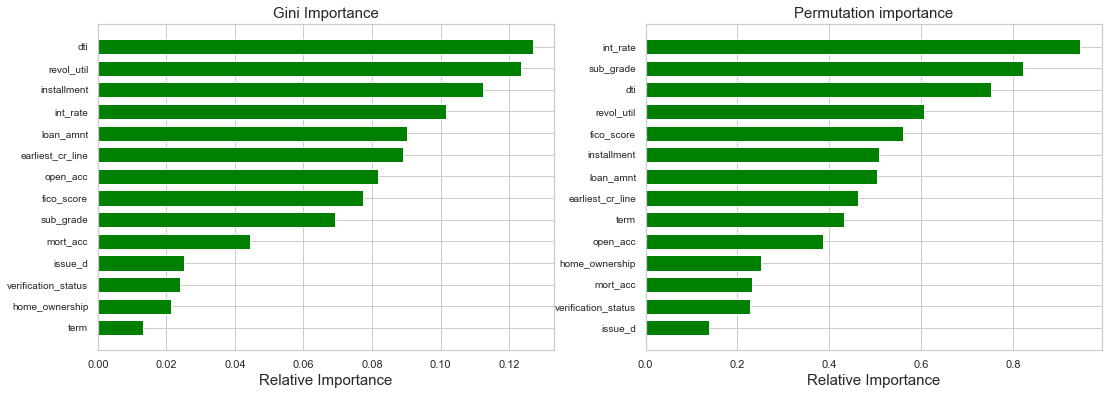

In [572]:
observations = 30000
#for i in np.arange(25):
print(i)
traindata = data_i.sample(observations)
X = traindata[traindata.columns[:-1]]
y = traindata[traindata.columns[-1]] 
X_train, X_test, y_train, y_test = split_(X,y)
criterion = "entropy"
forest = RandomForestClassifier(n_estimators=100, max_features = "sqrt",criterion=criterion)
forest.fit(X_train, y_train)
auc = metrics.roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1]) 
        #accuracy  = metrics.accuracy_score(y_test, forest.predict(X_test))            
        #mcc = metrics.matthews_corrcoef(y_test, forest.predict(X_test))
print(auc)
Plot_predictor_importance(forest,traindata) 

In [587]:
observations = 30000
ginis = [[], [], [], [], [], [], [], [], [], [], [], [], [], []]
for i in np.arange(25):
    print(i)
    traindata = data_i.sample(observations)
    X = traindata[traindata.columns[:-1]]
    y = traindata[traindata.columns[-1]] 
    X_train, X_test, y_train, y_test = split_(X,y)
    criterion = "gini"
    forest = RandomForestClassifier(n_estimators=100, max_features = "sqrt",criterion=criterion)
    forest.fit(X_train, y_train)
    auc = metrics.roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1]) 
    gini_importances = forest.feature_importances_.tolist()
    #print(gini_importances[2])
    perm_imp_rfpimp = permutation_importances(forest, X_train, y_train, r2)
    for idx in np.arange(len(traindata.columns[:-1])):
        e = gini_importances[idx]
        ginis[idx].append(e)
    
        #accuracy  = metrics.accuracy_score(y_test, forest.predict(X_test))            
        #mcc = metrics.matthews_corrcoef(y_test, forest.predict(X_test))
    print(auc)
    #Plot_predictor_importance(forest,traindata) 

0
0.6387444253067835
1
0.6642394997394477
2
0.6323734606084958
3
0.6418293178705922
4
0.6285992658819448
5
0.6382122530287017
6
0.6527465762619884
7
0.6470660602453526
8
0.6285527605712948
9
0.6525327292012516
10
0.6331719313469177
11
0.6487901881533101
12
0.6513539582050493
13
0.6380122939312886
14
0.6389912468656689
15
0.6339662775082197
16
0.6517571442216832
17
0.6488351484315869
18
0.6325873188460414
19
0.6374007189318727
20
0.6476374602488685
21
0.6522778597153431
22
0.6534962192048135
23
0.6689979014696417
24
0.6422646594658851


In [612]:
d = dict(zip(traindata.columns[:-1],ginis))
gini_averages = ((sum(ginis) / len(ginis), s) for s, ginis in d.items())
dd = sorted(gini_averages, reverse=True)
name = [i[1] for i in dd ]
score = [i[0] for i in dd ]

[0.12952641503143916,
 0.12492403755113678,
 0.11432887950575507,
 0.09579001301634565,
 0.09142811949401708,
 0.09131706249429777,
 0.08247564458334848,
 0.07418355964480275,
 0.0658347370323543,
 0.044783730610996324,
 0.025415946610739096,
 0.02462153262479297,
 0.02204945923009928,
 0.01332086256987528]

In [616]:
sortname = sorted(d, key=lambda k: sum(d[k]) / len(d[k]), reverse=True)
for i in sortname:
    

['dti',
 'revol_util',
 'installment',
 'int_rate',
 'loan_amnt',
 'earliest_cr_line',
 'open_acc',
 'fico_score',
 'sub_grade',
 'mort_acc',
 'issue_d',
 'verification_status',
 'home_ownership',
 'term']

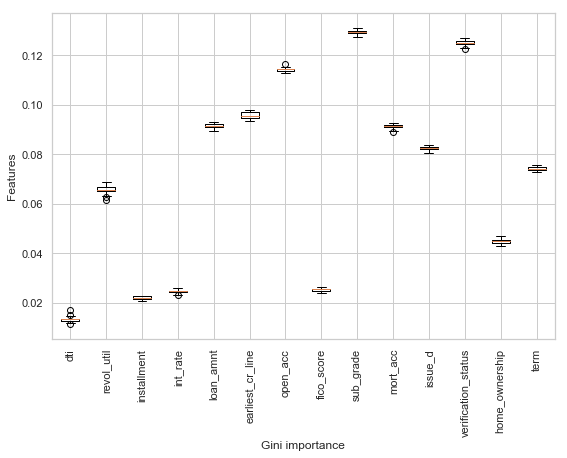

In [613]:
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(ginis)

ax.plot()
## Custom x-axis labels
ax.set_xticklabels(name,rotation =90)

ax.set_xlabel('Gini importance'); ax.set_ylabel('Features');
#fig.savefig('pic 6-2#30000 from 2007-2013 and test on different # observations in 2015.png', bbox_inches='tight')

In [548]:
# null case
observations = 30000
#for i in np.arange(25):
print(i)
traindata = data_i
X = traindata[traindata.columns[:-1]].sample(observations)
y = traindata[traindata.columns[-1]].sample(observations)
X_train, X_test, y_train, y_test = split_(X,y)
criterion = "entropy"
forest = RandomForestClassifier(n_estimators=100, max_features = "sqrt",criterion=criterion)
forest.fit(X_train, y_train)
auc = metrics.roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1]) 
        #accuracy  = metrics.accuracy_score(y_test, forest.predict(X_test))            
        #mcc = metrics.matthews_corrcoef(y_test, forest.predict(X_test))
print(auc)

24
0.49385949305107274


1902232    0
1638466    0
1802338    1
1798520    0
1776006    0
Name: y, dtype: int64

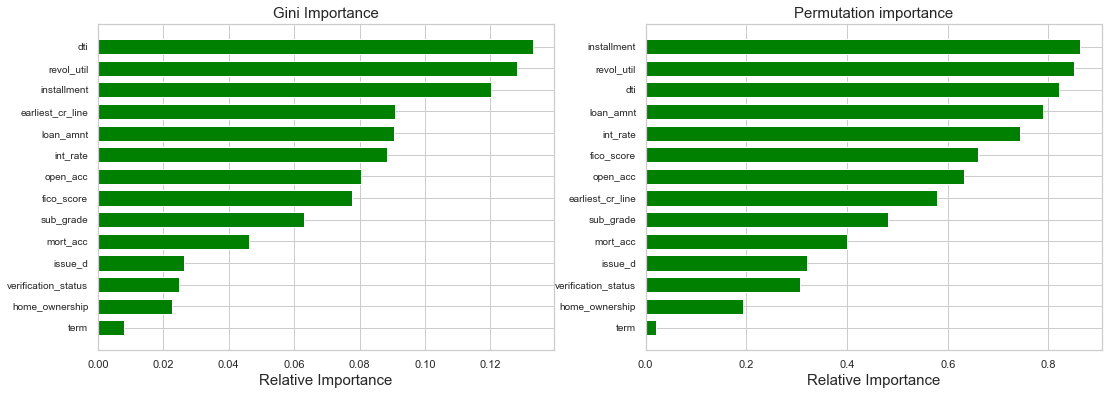

In [549]:
Plot_predictor_importance(forest,traindata) 

In [534]:
data_i_1 = data_i[data["y"]==1].sample(10000)
data_i_0 = data_i[data["y"]==0].sample(20000)
data_bal = pd.concat([data_i_1,data_i_0],axis = 0)
data_bal.shape

/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


(30000, 15)

In [539]:
X_train, X_test, y_train, y_test = split_(data_bal[data_bal.columns[:-1]],data_bal[data_bal.columns[-1]])
criterion = "entropy"
forest = RandomForestClassifier(n_estimators=100, max_features = "sqrt",criterion=criterion)
forest.fit(X_train, y_train)
auc = metrics.roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1]) 
        #accuracy  = metrics.accuracy_score(y_test, forest.predict(X_test))            
        #mcc = metrics.matthews_corrcoef(y_test, forest.predict(X_test))
        #print(auc)
print(auc)
unique, counts = np.unique(forest.predict(X_test), return_counts=True)
dict(zip(unique, counts))

#print(np.ravel(forest.predict(X_test)).count())

0.6400791467327901


{0: 4986, 1: 1014}

term  sub_grade  home_ownership  verification_status  loan_amnt  \
1611879     0          6               5                    2     5000.0   
1611880     1         13               5                    1     2500.0   
1611881     0         14               5                    0     2400.0   
1611882     0         10               5                    1    10000.0   
1611883     1          9               5                    1     3000.0   

         int_rate  installment  issue_d    dti  earliest_cr_line  open_acc  \
1611879     10.65       162.87     2011  27.65              1985       3.0   
1611880     15.27        59.83     2011   1.00              1999       3.0   
1611881     15.96        84.33     2011   8.72              2001       2.0   
1611882     13.49       339.31     2011  20.00              1996      10.0   
1611883     12.69        67.79     2011  17.94              1996      15.0   

         revol_util  mort_acc  fico_score  y  
1611879        83.7  1.670783       737.0  0  
1611880         9.4  1.670783       742.0  1  
1611881        98.5  1.670783       737.0  0  
1611882        21.0  1.670783       692.0  0  
1611883        53.9  1.670783       697.0  0

24
0.6454168459149344


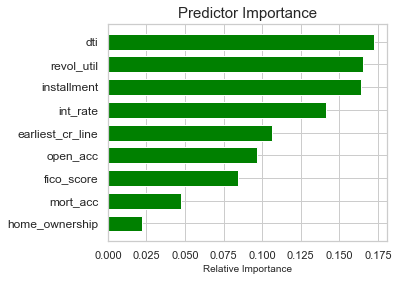

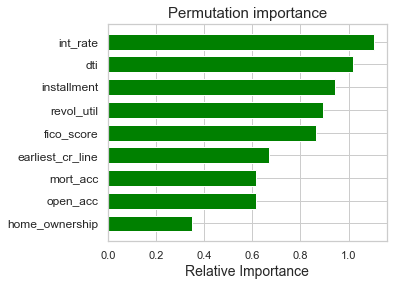

In [494]:
observations = 30000
#for i in np.arange(25):
print(i)
traindata = data_i.drop(["sub_grade","loan_amnt","term","issue_d","verification_status"],axis = 1)   
X_train, X_test, y_train, y_test = split_(traindata[traindata.columns[:-1]],traindata[traindata.columns[-1]])
criterion = "entropy"
forest = RandomForestClassifier(n_estimators=100, max_features = "sqrt",criterion=criterion)
forest.fit(X_train, y_train)
auc = metrics.roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1]) 
        #accuracy  = metrics.accuracy_score(y_test, forest.predict(X_test))            
        #mcc = metrics.matthews_corrcoef(y_test, forest.predict(X_test))
        #print(auc)
print(auc)       
Plot_predictor_importance(forest,traindata) 

def r2(forest, X_train, y_train):
    return r2_score(y_train, forest.predict(X_train))

perm_imp_rfpimp = permutation_importances(forest, X_train, y_train, r2)
fig, ax = plt.subplots(figsize = (5,4))
ax.barh(np.arange(len(perm_imp_rfpimp.values)),np.ravel(perm_imp_rfpimp.values), align='center',color='green', 
            ecolor='black', height= 0.7)
ax.set_yticks(np.arange(len(perm_imp_rfpimp.values)))
ax.set_yticklabels(perm_imp_rfpimp.index.values,fontsize = 12)
ax.invert_yaxis()
ax.set_xlabel('Relative Importance',fontsize = 14)
ax.set_title('Permutation importance',fontsize = 15)
plt.show()

24
0.6497348115169054


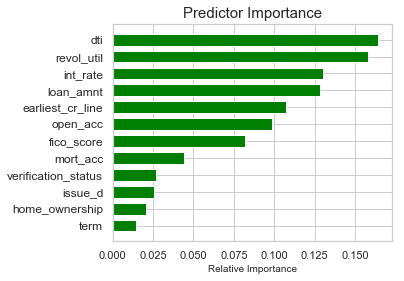

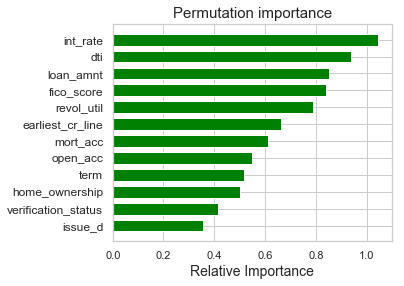

In [537]:
observations = 30000
#for i in np.arange(25):
print(i)
traindata = data_i.drop(["sub_grade","installment"],axis = 1)   
X_train, X_test, y_train, y_test = split_(traindata[traindata.columns[:-1]],traindata[traindata.columns[-1]])
criterion = "gini"
forest = RandomForestClassifier(n_estimators=100, max_features = "sqrt",criterion=criterion)
forest.fit(X_train, y_train)
auc = metrics.roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1]) 
        #accuracy  = metrics.accuracy_score(y_test, forest.predict(X_test))            
        #mcc = metrics.matthews_corrcoef(y_test, forest.predict(X_test))
        #print(auc)
print(auc)       
Plot_predictor_importance(forest,traindata) 

def r2(forest, X_train, y_train):
    return r2_score(y_train, forest.predict(X_train))

perm_imp_rfpimp = permutation_importances(forest, X_train, y_train, r2)
fig, ax = plt.subplots(figsize = (5,4))
ax.barh(np.arange(len(perm_imp_rfpimp.values)),np.ravel(perm_imp_rfpimp.values), align='center',color='green', 
            ecolor='black', height= 0.7)
ax.set_yticks(np.arange(len(perm_imp_rfpimp.values)))
ax.set_yticklabels(perm_imp_rfpimp.index.values,fontsize = 12)
ax.invert_yaxis()
ax.set_xlabel('Relative Importance',fontsize = 14)
ax.set_title('Permutation importance',fontsize = 15)
plt.show()

In [504]:
conda install pygraphviz

Solving environment: done

## Package Plan ##

  environment location: /Users/hui/anaconda3

  added / updated specs:
    - pygraphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cairo-1.14.12              |       hc4e6be7_4         1.2 MB
    conda-4.7.10               |           py37_0         3.0 MB
    conda-package-handling-1.3.11|           py37_0         260 KB
    fontconfig-2.13.0          |       h5d5b041_1         245 KB
    fribidi-1.0.5              |       h1de35cc_0          62 KB
    graphite2-1.3.13           |       h2098e52_0          83 KB
    graphviz-2.40.1            |       hefbbd9a_2         6.7 MB
    harfbuzz-1.8.8             |       hb8d4a28_0         703 KB
    pango-1.42.4               |       h060686c_0         523 KB
    pixman-0.38.0              |       h1de35cc_0         611 KB
    pygraphviz-1.3             |   py37h1de35cc_1         108 KB
  

In [515]:
estimator = forest.estimators_[5]
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = traindata.columns[:-1],
                class_names = ["fully paid","charged off"],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [412]:
import eli5
# create our dataframe of feature importances
feat_imp_df = eli5.explain_weights_df(forest, feature_names=data.columns)
feat_imp_df

ModuleNotFoundError: No module named 'eli5'

AUC: 0.706


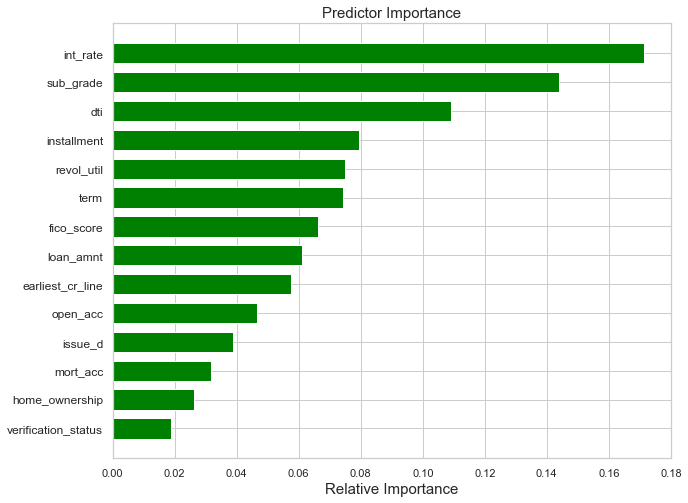

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=40,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [241]:
X_train, X_test, y_train, y_test = split_(df_lessvar[df_lessvar.columns[:-1]],df_lessvar[df_lessvar.columns[-1]])
rf(X_train, X_test, y_train, y_test,"gini")

(249855, 22)

In [215]:
df2.sample()

term  sub_grade  home_ownership  verification_status  loan_amnt  \
277736     0          4               5                    0     8000.0   

        int_rate  installment  issue_d   dti  earliest_cr_line  open_acc  \
277736      7.89       250.29     2015  4.58              2006       4.0   

        revol_util  mort_acc  fico_score  y  
277736        80.8       0.0       662.0  0